## Predict the Rossomann Store Sales with Time Series Data (Prophet)

### 01. Importing the Libraries

In [98]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet import Prophet

### 02 . Reading the Data

In [99]:
train = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')

In [100]:
train.shape


(1017209, 9)

In [101]:
train.head()


Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [102]:
store.head()


Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

### 03. Data Processing 

There are open stores with no sales on regular working days. Since the data spans only 54 days, we can assume that external factors may have played a role, such as protests or demonstrations.

In [103]:
train=train[(train['Sales']!=0) & (train['Open']!=0)]
train['SalesPerCustomer'] = train['Sales']/train['Customers']

In [104]:
train.shape


(844338, 10)

- Remove the duplicated rows

In [105]:
train = train.drop_duplicates()
store = store.drop_duplicates()

- Dealing the missing values

In [106]:
train.isnull().sum()

Store               0
DayOfWeek           0
Date                0
Sales               0
Customers           0
Open                0
Promo               0
StateHoliday        0
SchoolHoliday       0
SalesPerCustomer    0
dtype: int64

In [107]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [108]:
# missing values in CompetitionDistance
store[pd.isna(store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [109]:
# This code snippet replaces missing values in the 'CompetitionDistance' column of the 'store' DataFrame with the median value.
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)


In [110]:
#The missing values, are not there, because the stores had no competition. So I would suggest to fill the missing values with zeros.
store.fillna(0, inplace = True)

In [111]:
# Find the index of rows where 'Promo2' is 0 and 'PromoInterval' is null.
index = store[(store['Promo2'] == 0) & (store['PromoInterval'].isnull())].index

# Set the 'PromoInterval' to 0 for the rows with the specified index.
store.loc[index, 'PromoInterval'] = 0

# Change the data type of the 'Promo2' column to object (likely to treat it as a categorical variable).
store['Promo2'] = store['Promo2'].astype(object)


- Dealing the Categorical Columns

In [112]:
cols = ['CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear',
       'Promo2SinceWeek',
       'Promo2SinceYear']
store[cols]=store[cols].astype(int)
store.select_dtypes(int).columns

Index(['Store', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear'],
      dtype='object')

In [113]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth      int32
CompetitionOpenSinceYear       int32
Promo2                        object
Promo2SinceWeek                int32
Promo2SinceYear                int32
PromoInterval                 object
dtype: object

In [114]:
train.select_dtypes('object').columns

Index(['Date', 'StateHoliday'], dtype='object')

In [115]:
train.StateHoliday.value_counts()

0    731308
0    112120
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [116]:
# Map and transform values in the 'StateHoliday' column based on the specified dictionary.
train['StateHoliday'] = train['StateHoliday'].map({0: 0, "0": 0, "a": 'Public Holiday', "b": 'Easter holiday', "c": 'Christmas'})


- Merge the Train data and Store Data

In [117]:
# Perform an inner join between the 'train' and 'store' DataFrames using the 'Store' column as the key.
train_store = pd.merge(train, store, how='inner', on='Store')

# The resulting DataFrame 'train_store' contains combined information from both 'train' and 'store' DataFrames.

In [118]:
# Define a function named 'featured_date' that takes a DataFrame 'df' as input.
def featured_date(df):
    # Convert the 'Date' column to a datetime format using the specified format.
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['Date'] = df['Date'].astype("datetime64[ns]")
    
    # Extract various date-related features and add them as new columns to the DataFrame.
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year 
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    
    return df  # Return the modified DataFrame.

# Apply the 'featured_date' function to the 'train_store' DataFrame.
featured_date(train_store)

# Set the 'Date' column as the DataFrame's index, effectively using it as the index for date


Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0           1          5 2015-07-31   5263        555     1      1   
1           1          4 2015-07-30   5020        546     1      1   
2           1          3 2015-07-29   4782        523     1      1   
3           1          2 2015-07-28   5011        560     1      1   
4           1          1 2015-07-27   6102        612     1      1   
...       ...        ...        ...    ...        ...   ...    ...   
844333    292          1 2013-01-07   9291       1002     1      1   
844334    292          6 2013-01-05   2748        340     1      0   
844335    292          5 2013-01-04   4202        560     1      0   
844336    292          4 2013-01-03   4580        662     1      0   
844337    292          3 2013-01-02   5076        672     1      0   

       StateHoliday  SchoolHoliday  SalesPerCustomer  ...  \
0                 0              1          9.482883  ...   
1                 0              1          9.194139  ...   
2                 0              1          9.143403  ...   
3                 0              1          8.948214  ...   
4                 0              1          9.970588  ...   
...             ...            ...               ...  ...   
844333            0              0          9.272455  ...   
844334            0              0          8.082353  ...   
844335            0              1          7.503571  ...   
844336            0              1          6.918429  ...   
844337            0              1          7.553571  ...   

       CompetitionOpenSinceMonth CompetitionOpenSinceYear  Promo2  \
0                              9                     2008       0   
1                              9                     2008       0   
2                              9                     2008       0   
3                              9                     2008       0   
4                              9                     2008       0   
...                          ...                      ...     ...   
844333                         6                     2009       0   
844334                         6                     2009       0   
844335                         6                     2009       0   
844336                         6                     2009       0   
844337                         6                     2009       0   

        Promo2SinceWeek  Promo2SinceYear PromoInterval  Day  Month  Year  \
0                     0                0             0   31      7  2015   
1                     0                0             0   30      7  2015   
2                     0                0             0   29      7  2015   
3                     0                0             0   28      7  2015   
4                     0                0             0   27      7  2015   
...                 ...              ...           ...  ...    ...   ...   
844333                0                0             0    7      1  2013   
844334                0                0             0    5      1  2013   
844335                0                0             0    4      1  2013   
844336                0                0             0    3      1  2013   
844337                0                0             0    2      1  2013   

        WeekOfYear  
0               31  
1               31  
2               31  
3               31  
4               31  
...            ...  
844333           2  
844334           1  
844335           1  
844336           1  
844337           1  

[844338 rows x 23 columns]

### 0.4 Exploratory Data Analysis

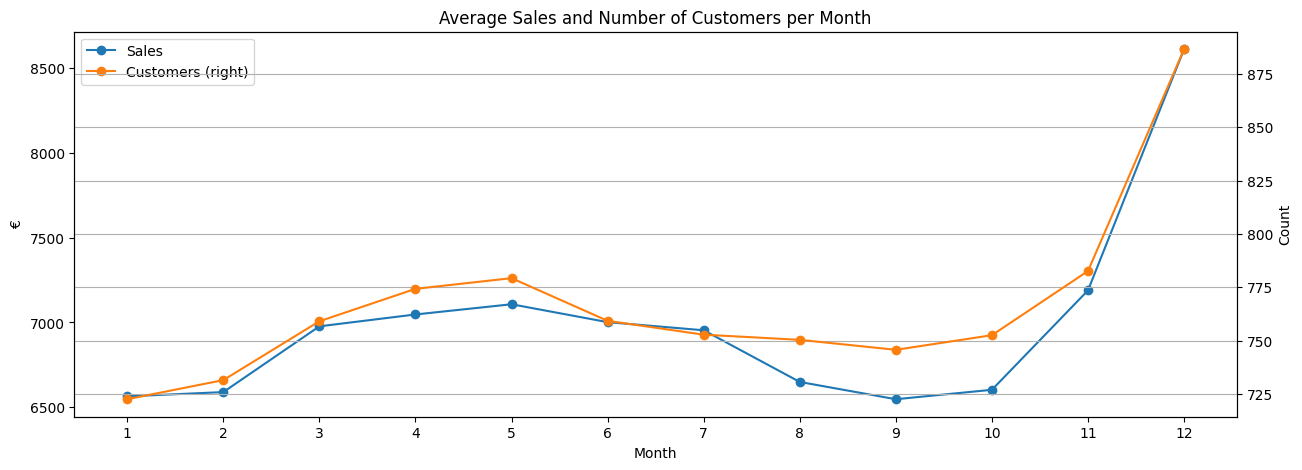

In [119]:
# Assuming you have a DataFrame 'train' with 'Sales' and 'Customers' data
# Group the data by 'Month', calculate the mean of 'Sales' and 'Customers', and create a line plot.
ax = train_store.groupby('Month')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15, 5), marker='o')

# Set the y-axis labels
ax.set_ylabel('€')  # Set the left y-axis label to '€' for Sales.
ax.right_ax.set_ylabel('Count')  # Set the right y-axis label to 'Count' for Customers.

# Set x-axis ticks to display months (assuming 'Month' is an integer from 1 to 12).
ax.set_xticks(range(1, 13))

# Set the title of the plot.
plt.title('Average Sales and Number of Customers per Month')

# Enable grid lines on the plot.
plt.grid(True)

# Show the plot.
plt.show()


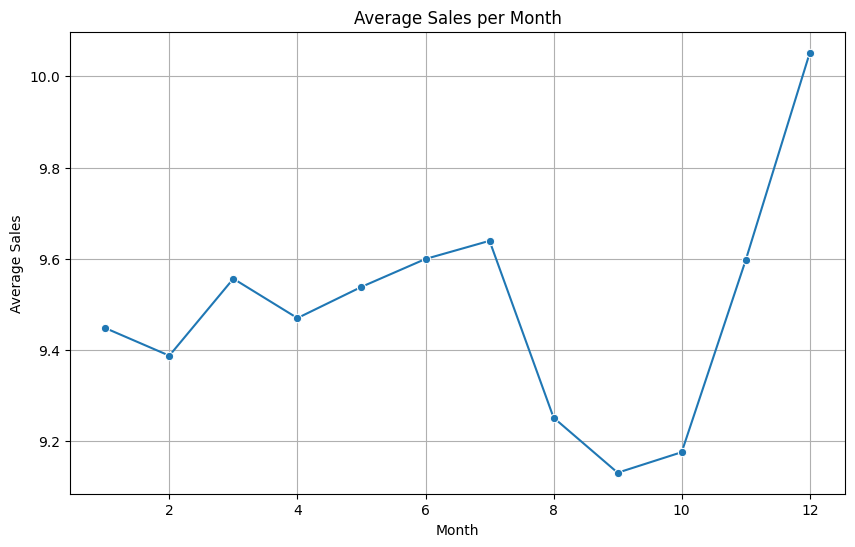

In [120]:
# Group the data by 'Month', calculate the mean of 'SalesPerCustomer', and create a line plot.
axis = train_store.groupby('Month')[['SalesPerCustomer']].mean()

# Create a figure with the specified size (you can adjust the size as needed).
plt.figure(figsize=(10, 6))

# Create a line plot using Seaborn, specifying the data, x-axis, y-axis, and marker style.
sns.lineplot(data=axis, x='Month', y='SalesPerCustomer', marker='o')

# Customize the plot: set title, x-axis label, y-axis label, and enable grid lines.
plt.title('Average Sales per Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(True)

# Show the plot.
plt.show()


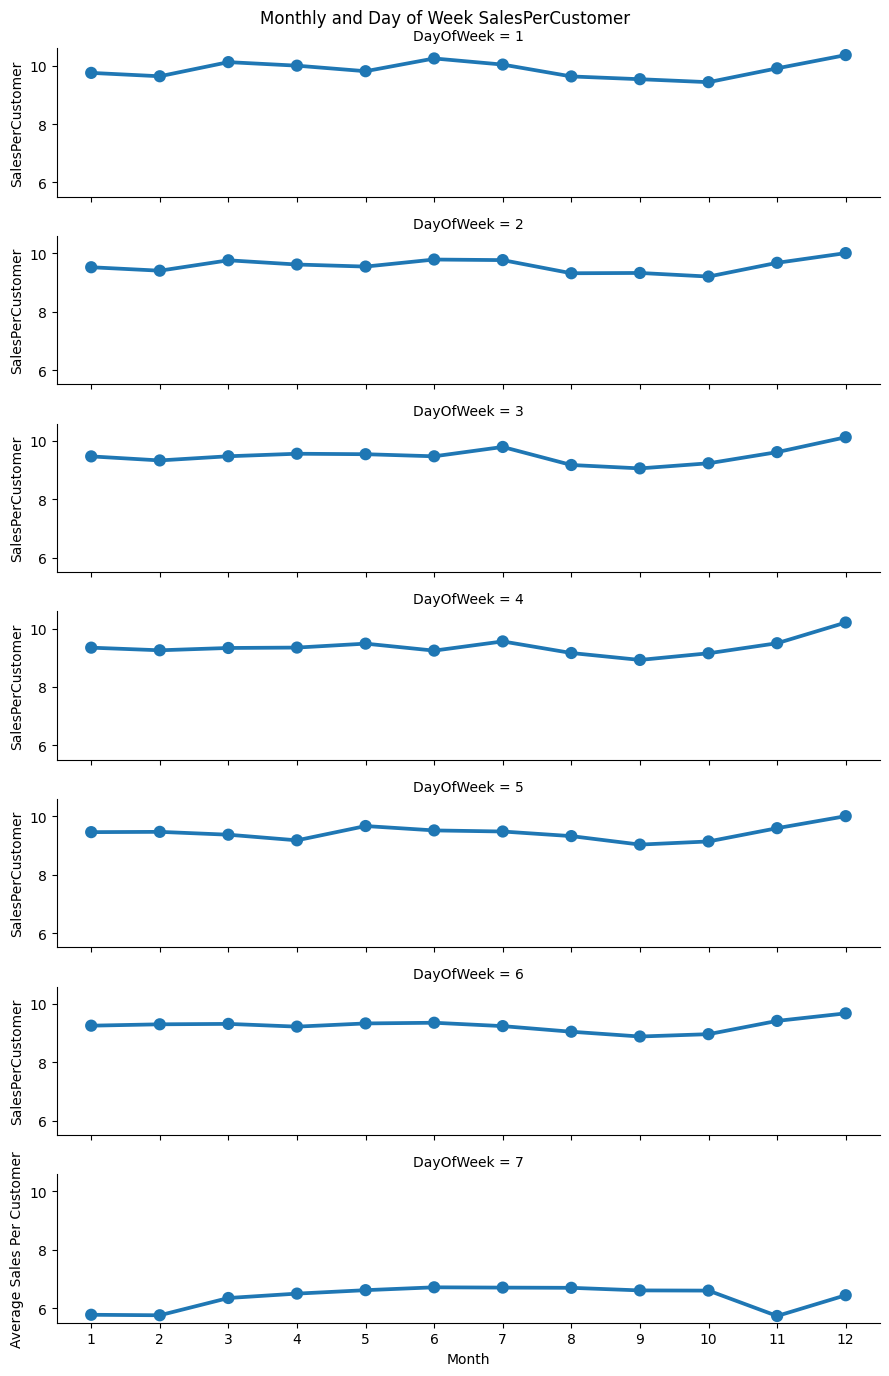

In [121]:
# Group the data by 'Month', 'DayOfWeek', and calculate the mean of 'SalesPerCustomer', then reset the index.
dayofweekbymonth = train_store.groupby(['Month', 'DayOfWeek'])['SalesPerCustomer'].mean().reset_index()

# Create a catplot using Seaborn, specifying data, x-axis, y-axis, row, plot type, height, and aspect.
sns.catplot(data=dayofweekbymonth, x='Month', y='SalesPerCustomer', row='DayOfWeek', kind='point', height=2, aspect=4.5)

# Customize the plot: set x-axis ticks, labels, title, and adjust layout.
plt.xticks()
plt.xlabel('Month')
plt.ylabel('Average Sales Per Customer')
plt.subplots_adjust(top=0.9)
plt.suptitle('Monthly and Day of Week SalesPerCustomer')
plt.tight_layout()

# Show the plot.
plt.show()


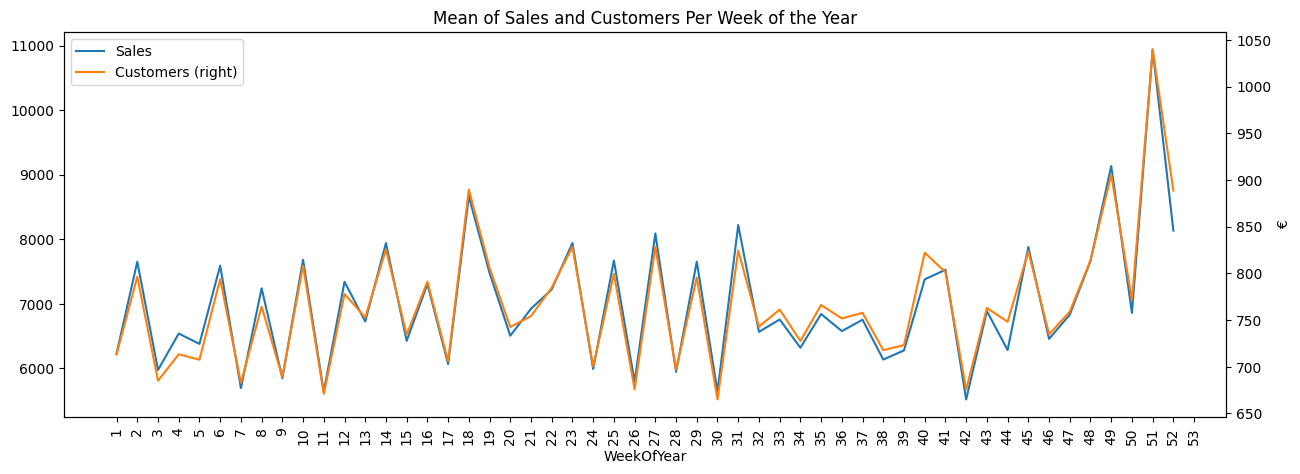

In [122]:
train_store.groupby('WeekOfYear')['Sales','Customers'].mean().plot(figsize=(15,5),secondary_y=['Customers'], xticks=np.arange(1,54), rot=90)
plt.title('Mean of Sales and Customers Per Week of the Year')
plt.ylabel('€')
plt.show()

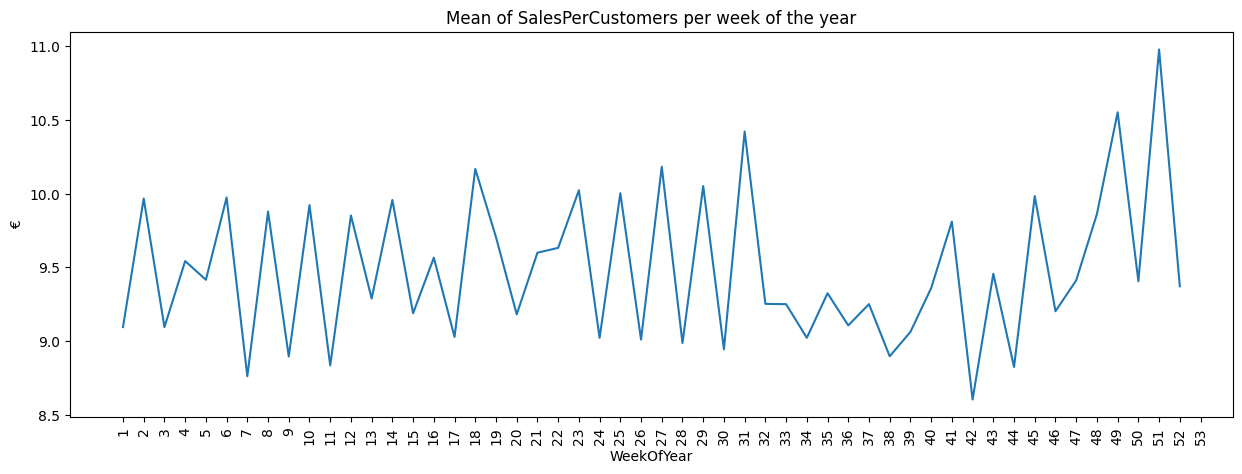

In [123]:
train_store.groupby('WeekOfYear')['SalesPerCustomer'].mean().plot(figsize=(15,5), xticks=np.arange(1,54), rot=90)
plt.title('Mean of SalesPerCustomers per week of the year')
plt.ylabel('€')
plt.show()

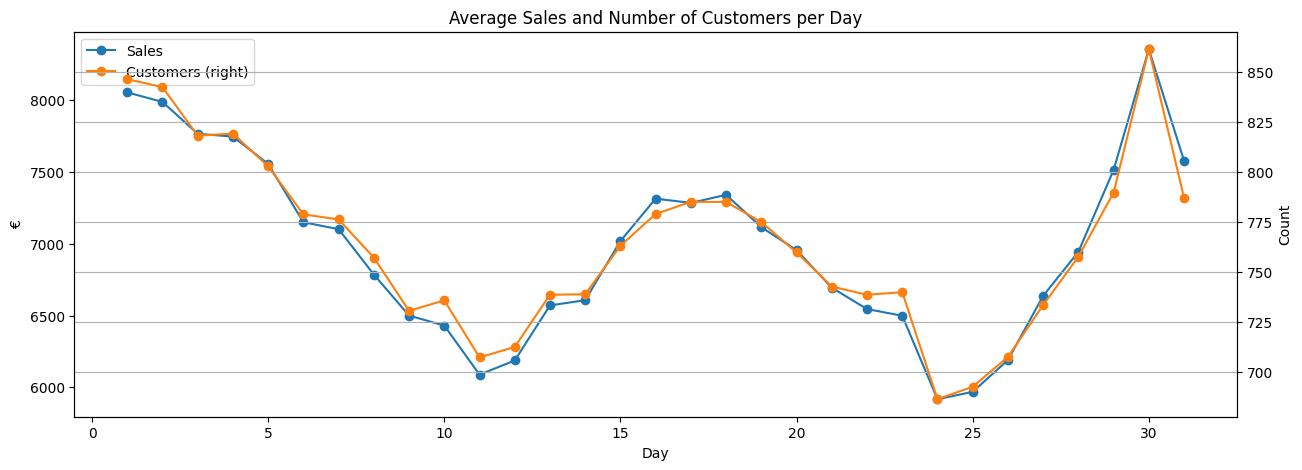

In [124]:
ax = train_store.groupby('Day')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15, 5), marker='o')

ax.set_ylabel('€')
ax.right_ax.set_ylabel('Count')

plt.title('Average Sales and Number of Customers per Day')
plt.grid(True)

# Show the plot
plt.show()

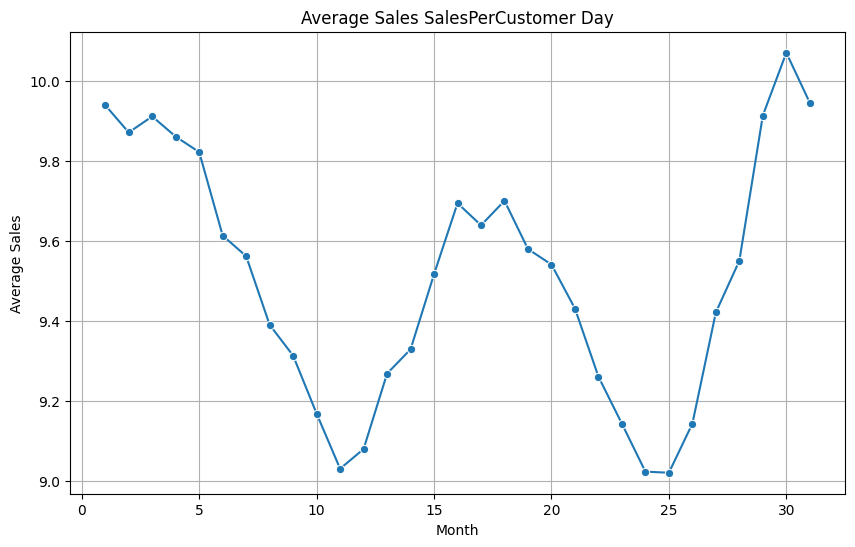

In [125]:
axis = train_store.groupby('Day')[['SalesPerCustomer']].mean()
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=axis, x='Day', y='SalesPerCustomer', marker='o')

# Customize the plot
plt.title('Average Sales SalesPerCustomer Day')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

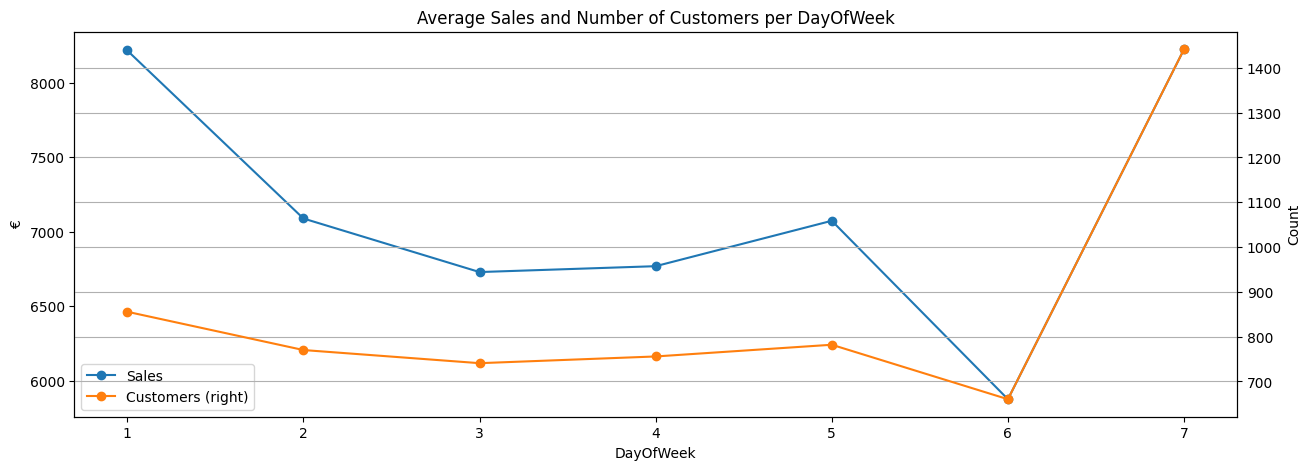

In [126]:
# Assuming you have a DataFrame 'train' with 'Sales' and 'Customers' data
ax = train_store.groupby('DayOfWeek')[['Sales', 'Customers']].mean().plot(secondary_y=['Customers'], figsize=(15, 5), marker='o')

# Set the y-axis labels
ax.set_ylabel('€')
ax.right_ax.set_ylabel('Count')

# Set x-axis ticks
ax.set_xticks(range(1, 8))

# Set the title
plt.title('Average Sales and Number of Customers per DayOfWeek')
plt.grid(True)

# Show the plot
plt.show()

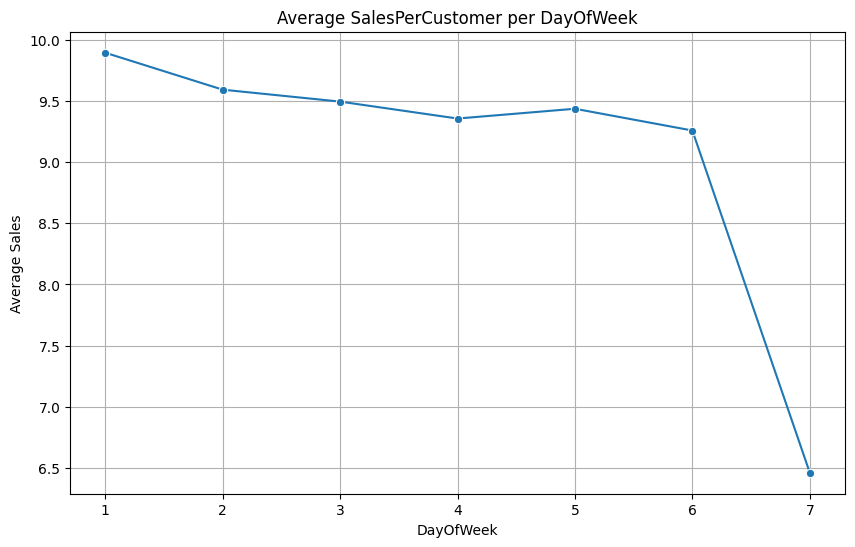

In [127]:
axis = train_store.groupby('DayOfWeek')[['SalesPerCustomer']].mean()
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=axis, x='DayOfWeek', y='SalesPerCustomer', marker='o')

# Customize the plot
plt.title('Average SalesPerCustomer per DayOfWeek')
plt.xlabel('DayOfWeek')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

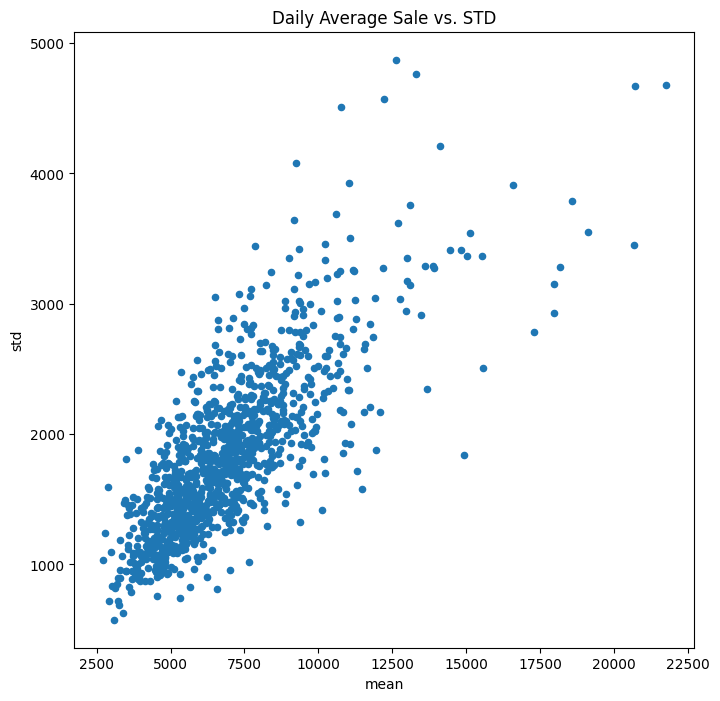

In [128]:
# Group the data by 'Store,' calculate the mean and standard deviation of 'Sales,' and sort by the mean value.
store_sale = train_store.groupby(['Store'])['Sales'].agg(['mean', 'std']).sort_values('mean')

# Create a scatter plot using the 'mean' as x-axis and 'std' as y-axis.
store_sale.plot.scatter('mean', 'std', figsize=(8, 8))

# Customize the plot: set title and show the plot.
plt.title('Daily Average Sale vs. STD')
plt.show()


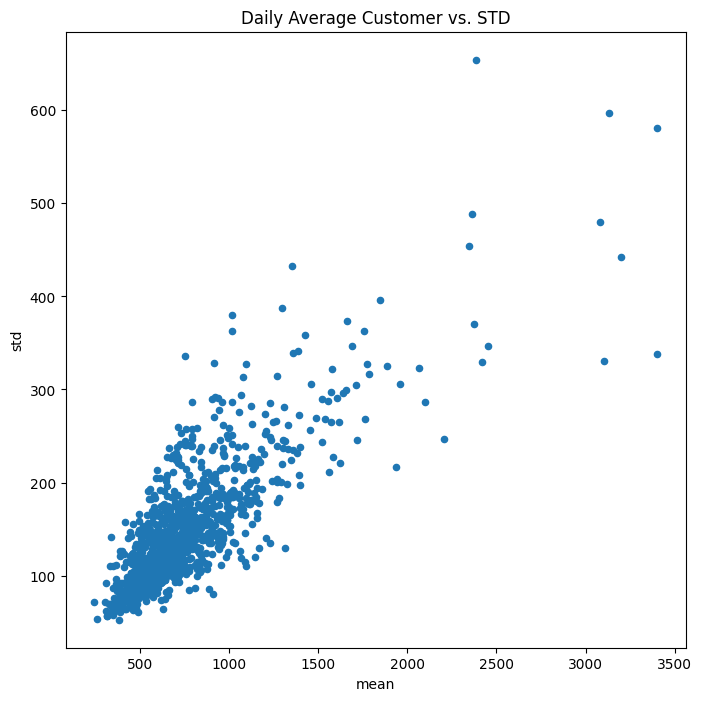

In [129]:
store_sale = train_store.groupby(['Store'])['Customers'].agg(['mean', 'std']).sort_values('mean')
store_sale.plot.scatter('mean', 'std', figsize=(8,8))
plt.title('Daily Average Customer vs. STD')
plt.show()

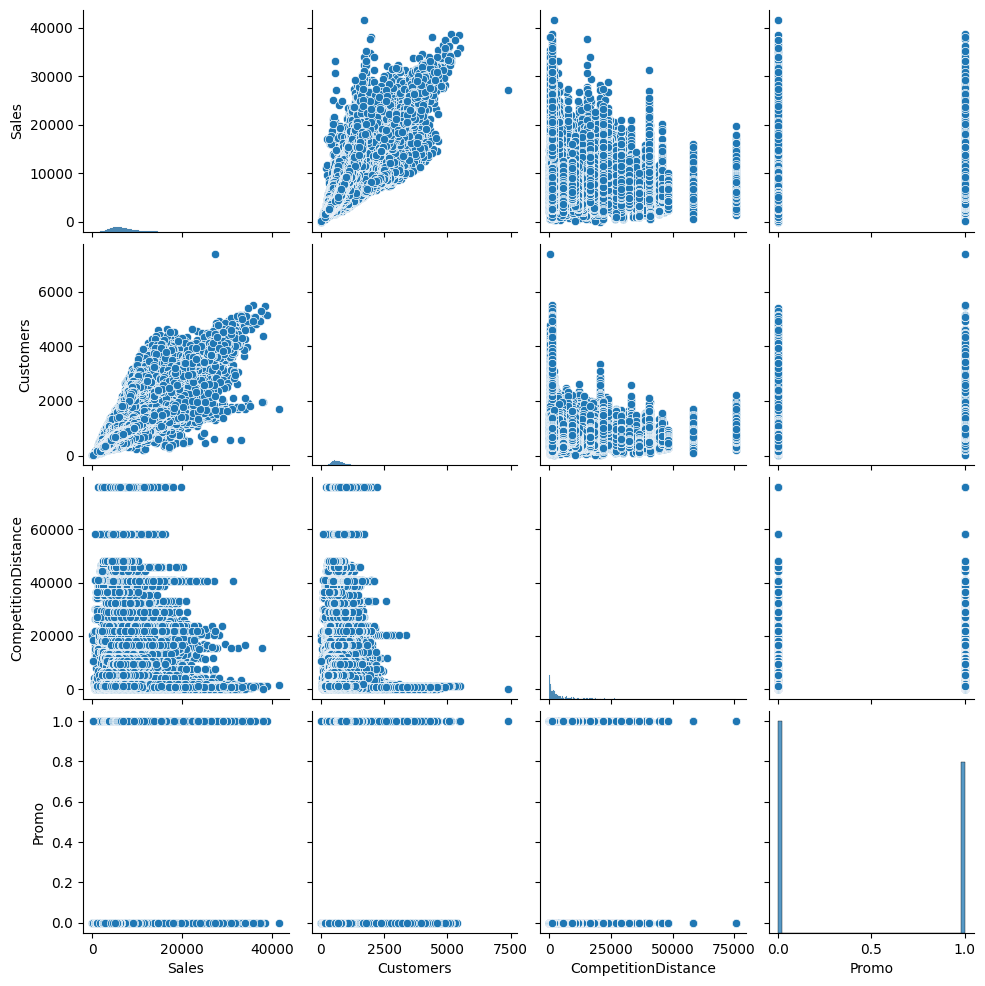

In [130]:
# Create a pair plot for selected variables from the 'train_store' DataFrame.
sns.pairplot(data=train_store[['Sales', 'Customers', 'CompetitionDistance', 'Promo']], kind='scatter')

# Show the pair plot.
plt.show()


In [131]:
# Group the 'train_store' DataFrame by the 'StoreType' column and compute summary statistics for the 'Sales' column.
train_store.groupby('StoreType')['Sales'].describe()


count          mean          std     min      25%     50%  \
StoreType                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   

                75%      max  
StoreType                     
a           8406.00  41551.0  
b          13184.25  38722.0  
c           8349.25  31448.0  
d           8123.25  38037.0

StoreType B has the highest average sales among all the other store types; however, we have considerably less data for it. To determine which StoreType is the most profitable and has the highest customer count, let's calculate the total sum of sales and customers for each StoreType.

In [132]:
# Group the 'train_store' DataFrame by the 'StoreType' column and calculate the sum of 'Customers' and 'Sales' for each group.
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()


Customers       Sales
StoreType                       
a          363541431  3165334859
b           31465616   159231395
c           92129705   783221426
d          156904995  1765392943

It's evident that stores of type A have the highest total sales and customer count. StoreType D comes in second place in both total sales and customers.

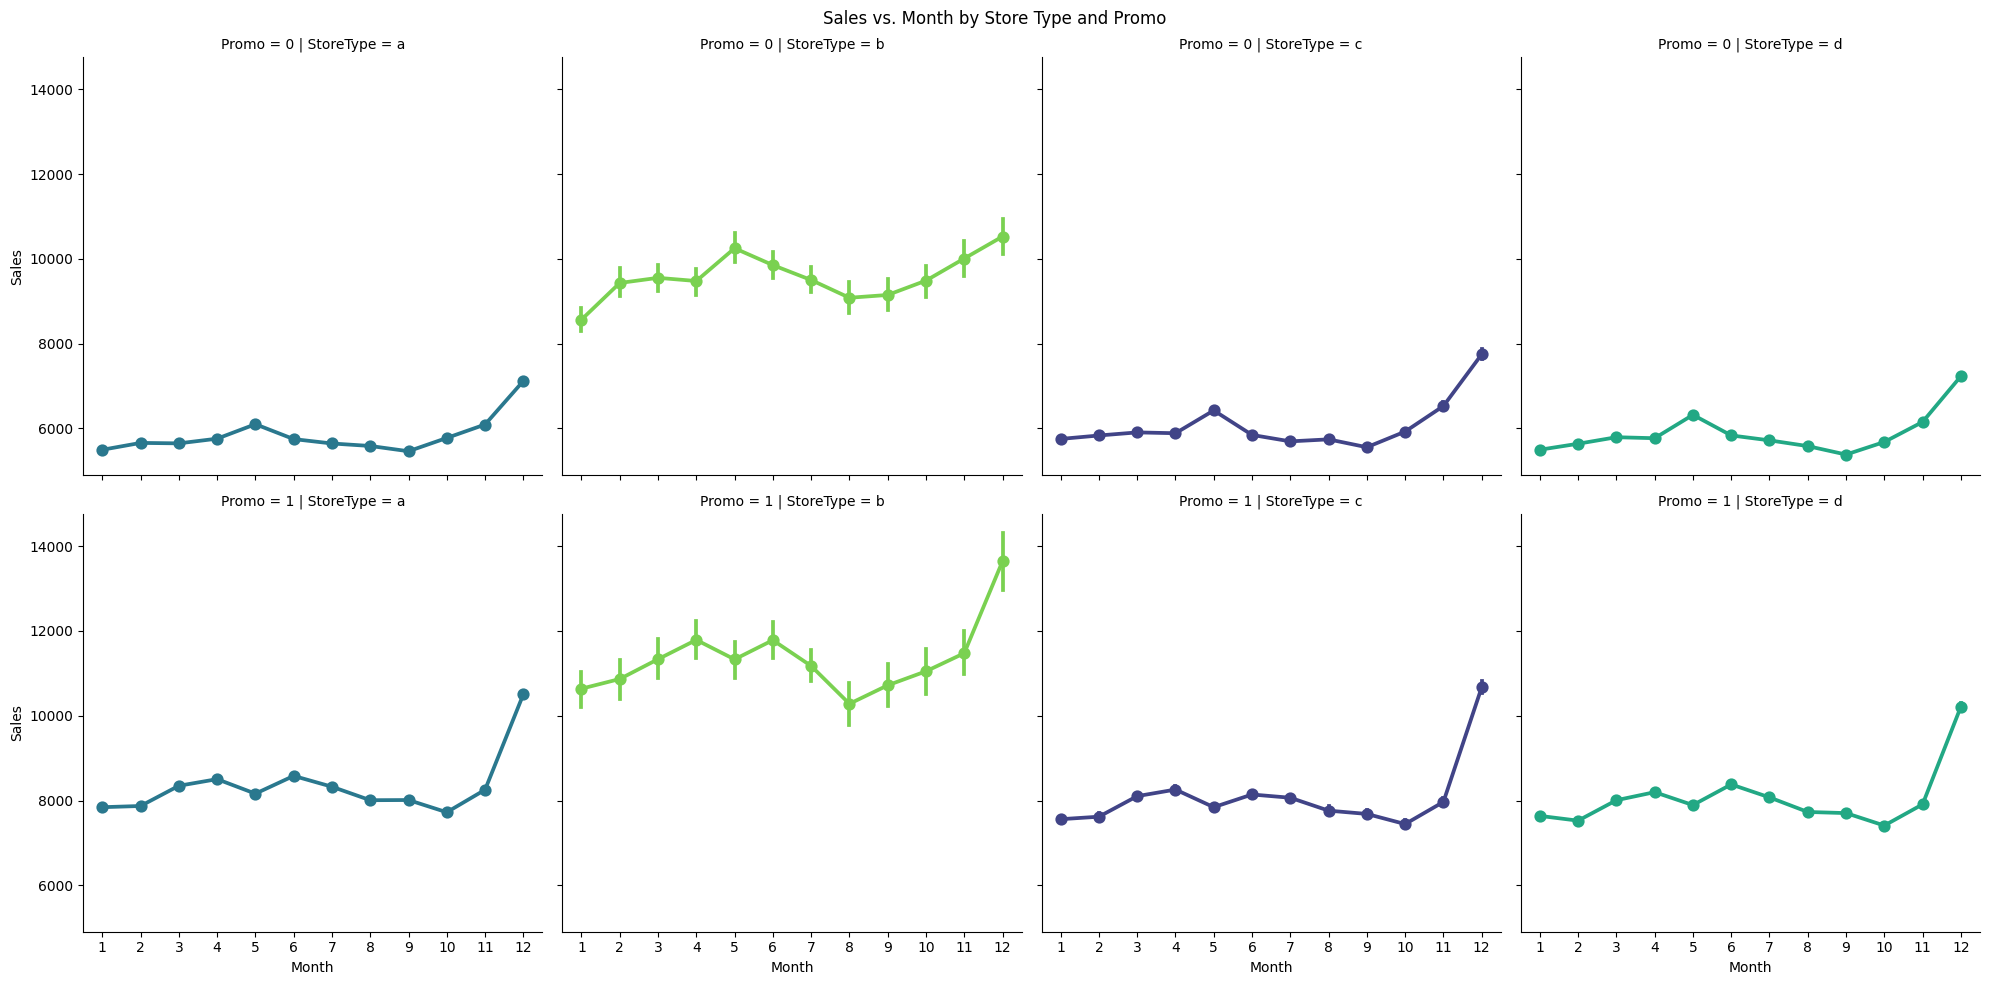

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of 'StoreType' categories for display.
storetype_order = ['a', 'b', 'c', 'd']

# Create the catplot using Seaborn.
g = sns.catplot(data=train_store, x='Month', y='Sales',
                col='StoreType', palette='viridis', hue='StoreType',
                row='Promo', kind='point', col_order=storetype_order)

# Customize the plot (optional).
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Sales vs. Month by Store Type and Promo')
plt.tight_layout()  # Automatically adjust to prevent overlapping

# Show the plot.
plt.show()


It appears that all store types exhibit similar trends, with variations in scale depending on the presence of the first promotion (Promo) and the specific StoreType (as seen in the case of StoreType B).

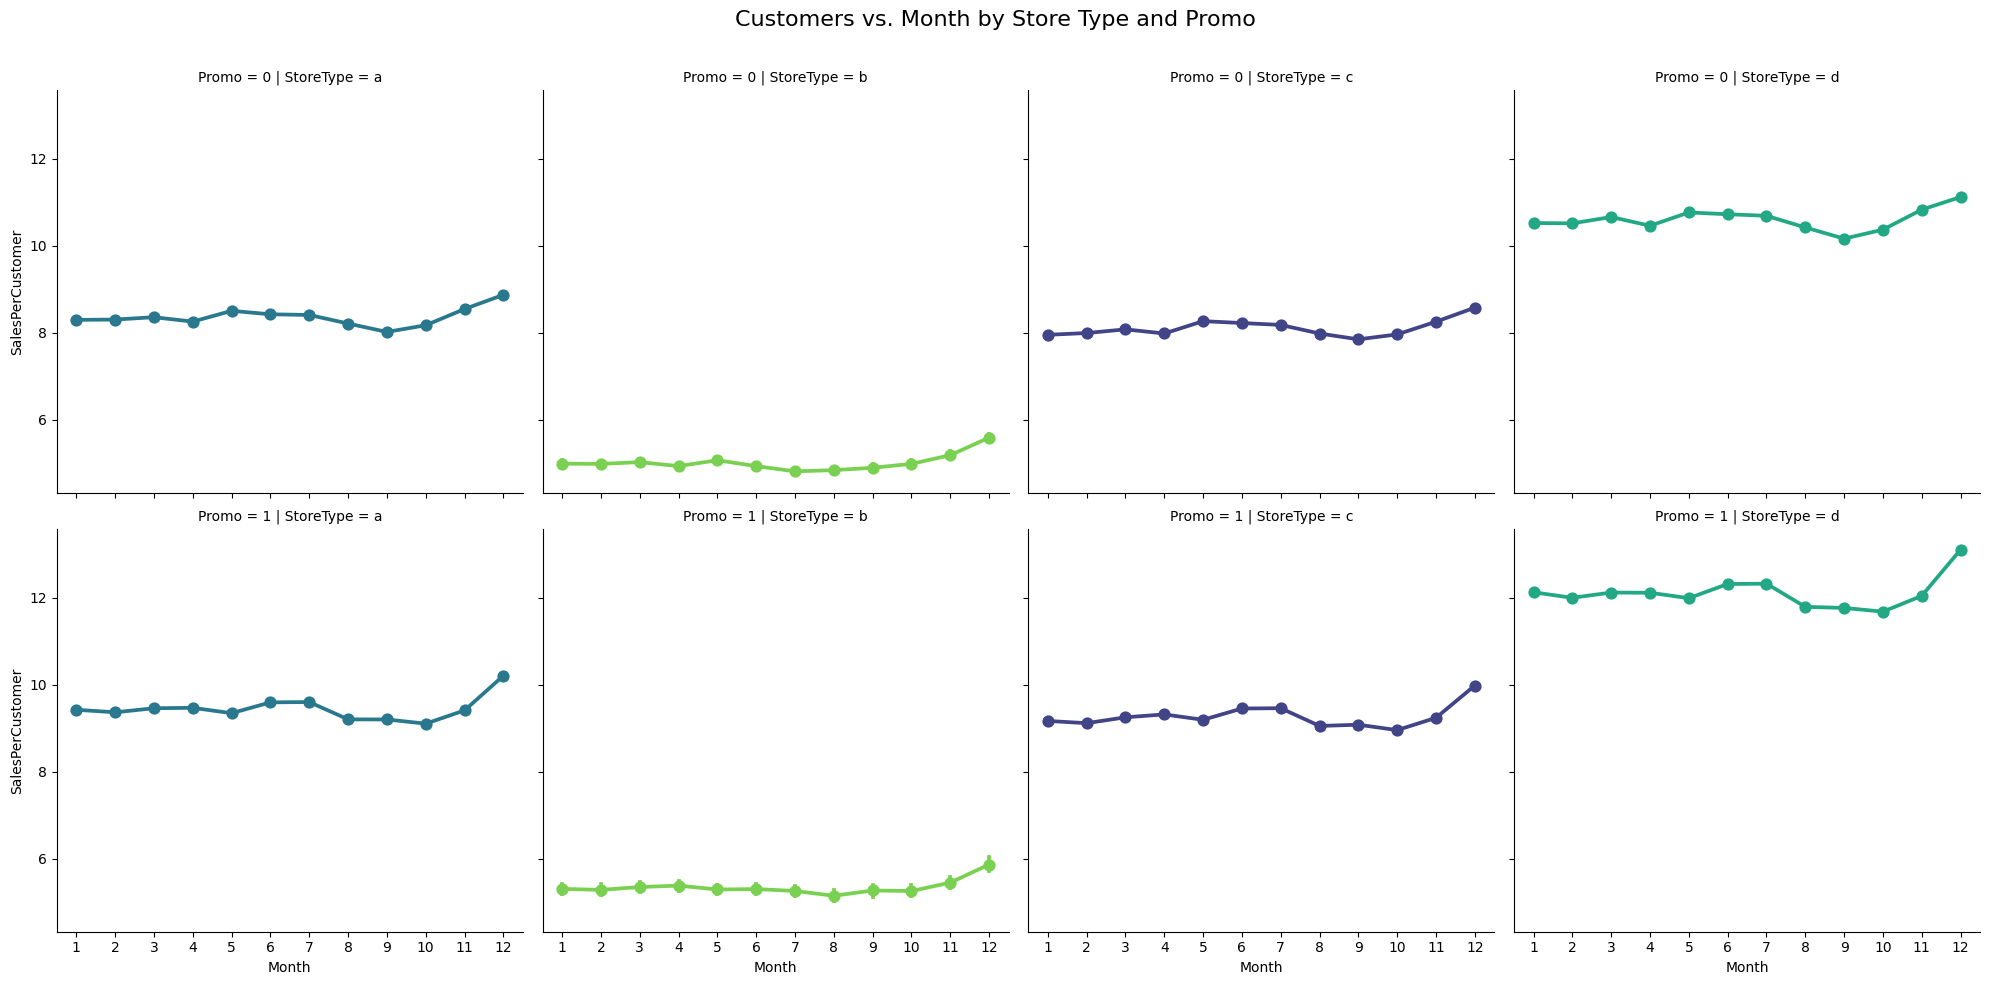

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_store is your DataFrame

# Create the catplot
g = sns.catplot(data=train_store, x='Month', y='SalesPerCustomer',
                col='StoreType', palette='viridis', hue='StoreType',
                row='Promo', kind='point', col_order=storetype_order)

# Customize the plot (optional)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Customers vs. Month by Store Type and Promo', fontsize=16)

# Show the plot
plt.show()


It's interesting to note that while the previous plots may have suggested that StoreType B was the most selling and performing type, in reality, that's not the case. The highest 'SalePerCustomer' amount is observed at StoreType D, which is around 12€ with Promo and 10€ without. StoreType A and StoreType C also have an 'SalePerCustomer' of about 9€.

The lower 'SalePerCustomer' amount for StoreType B indicates that their customers tend to purchase smaller or fewer items. This is further supported by the observation that StoreType B generated the least amount of total sales and had the lowest customer count over the given period.

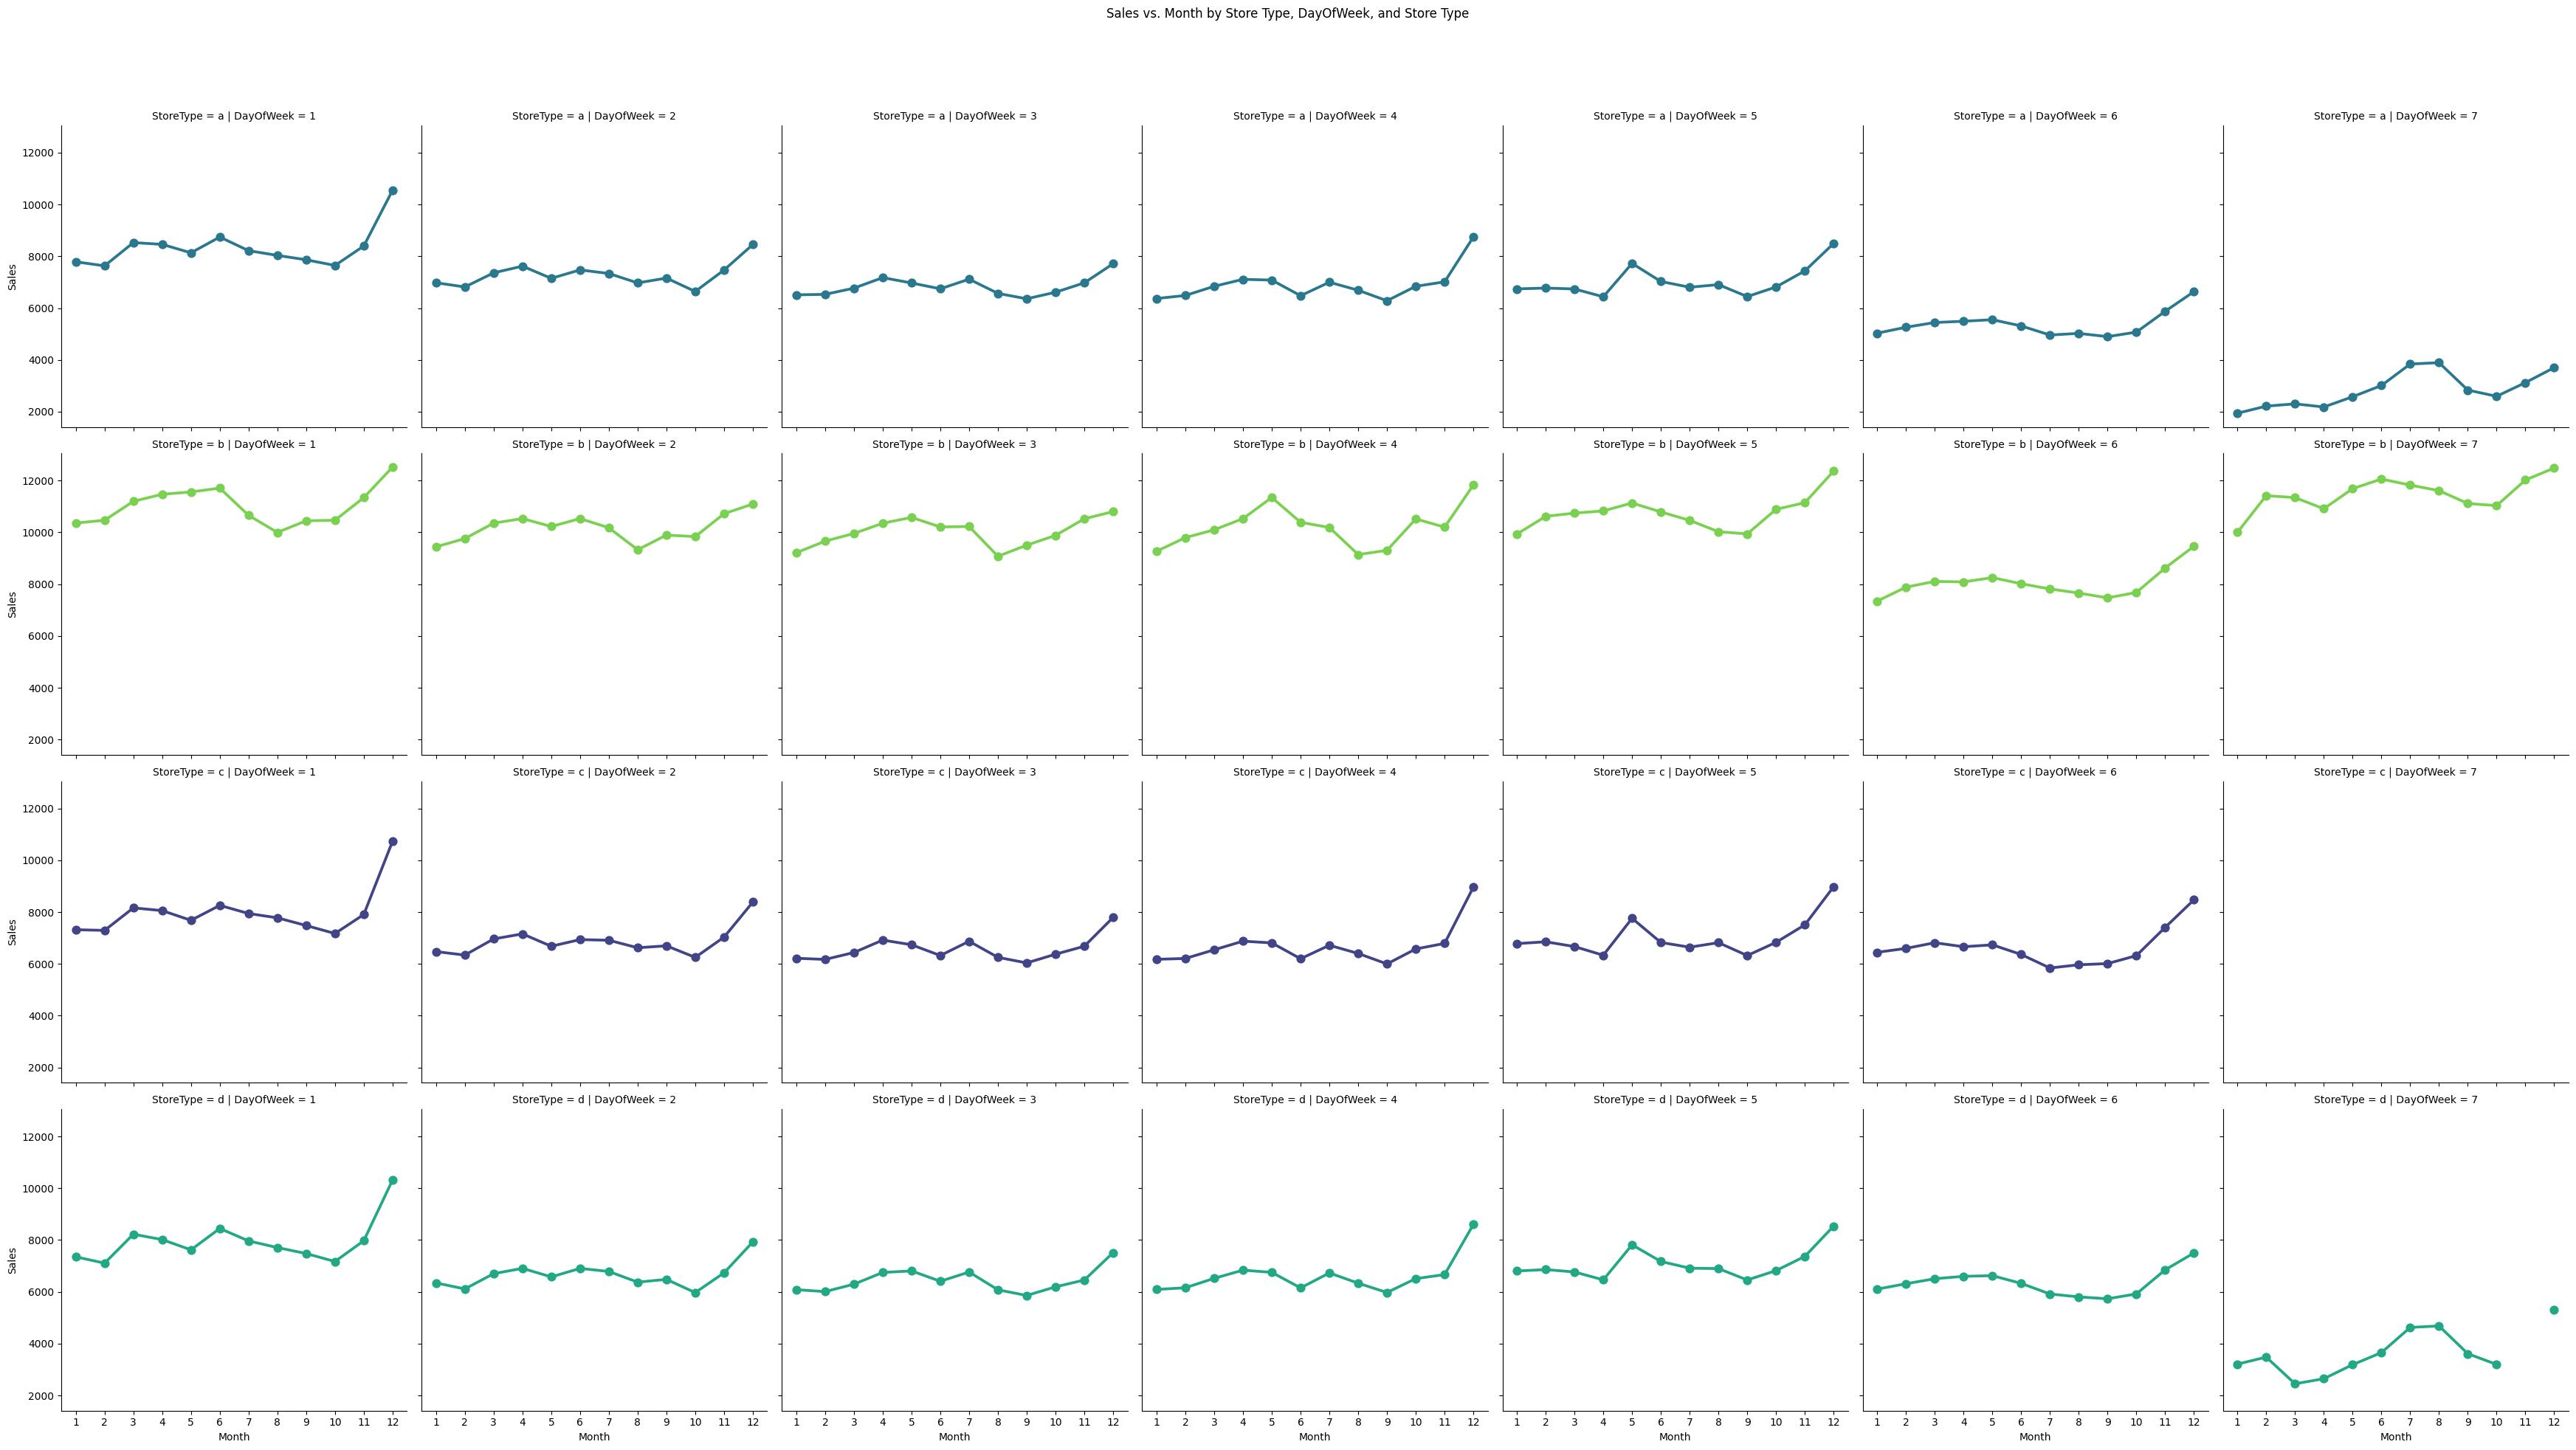

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_store is your DataFrame

# Create the catplot
g = sns.catplot(data=train_store, x='Month', y='Sales',
                col='DayOfWeek', palette='viridis', hue='StoreType',
                row='StoreType', kind='point', ci=None, row_order=storetype_order)

# Customize the plot (optional)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Sales vs. Month by Store Type, DayOfWeek, and Store Type')

# Show the plot
plt.show()


It's worth noting that stores of StoreType C are closed on Sundays throughout the year, while stores of other types are typically open most of the time. Interestingly, stores of StoreType D are only closed on Sundays from October to December, suggesting a variation in opening hours during that specific time frame.

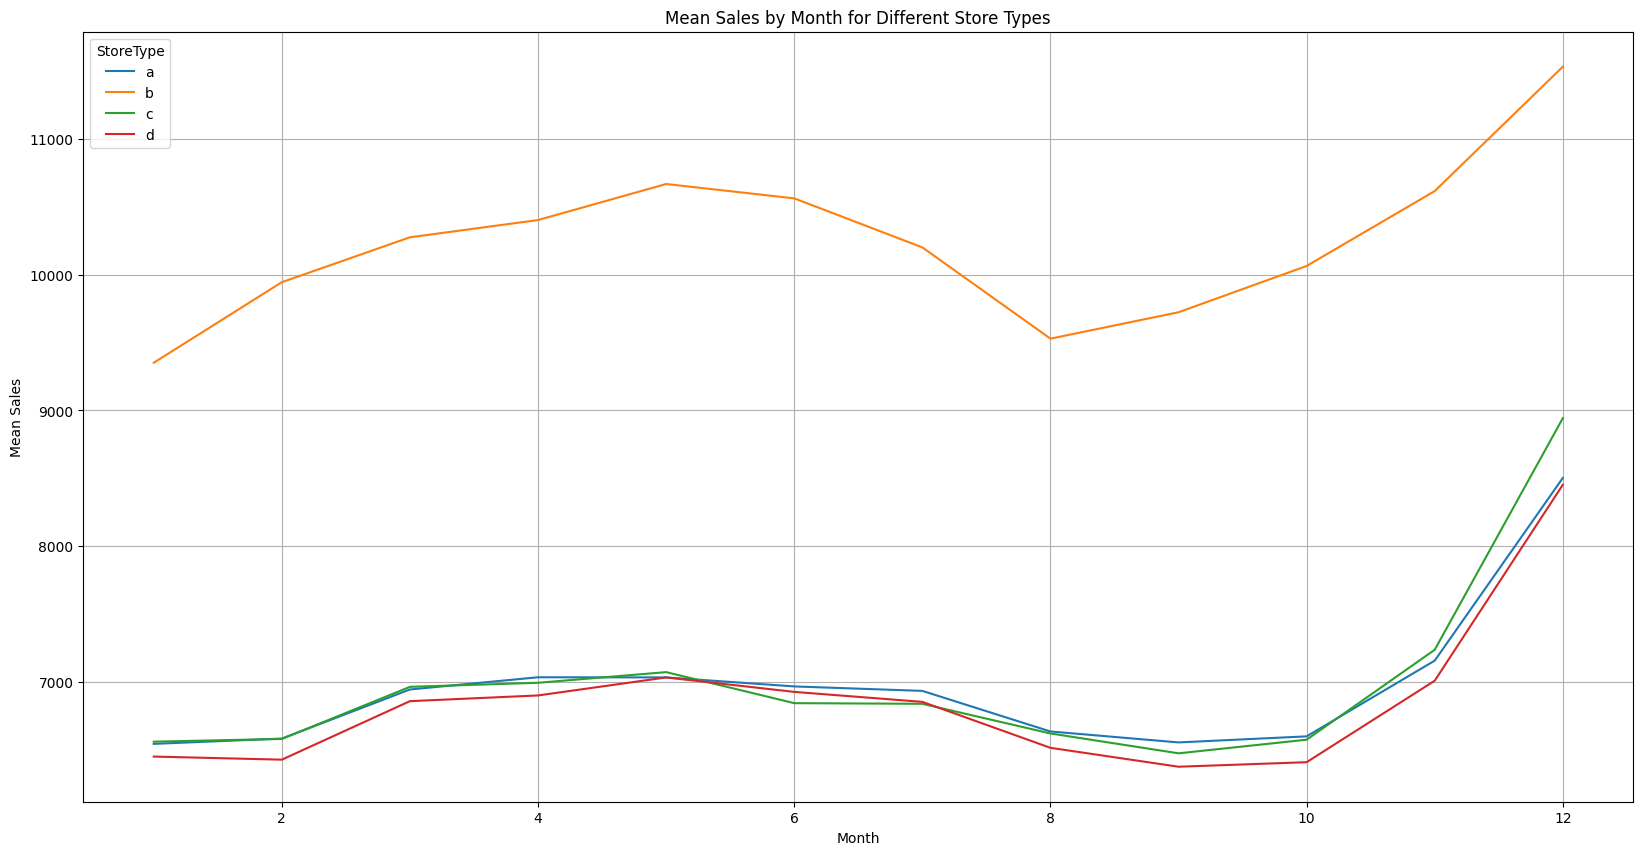

In [136]:
fig, ax = plt.subplots(figsize=(20, 10))

# Group the data by 'Date' and 'StoreType', calculate the mean of 'Sales', and unstack the result
# This will give you a DataFrame with 'Date' as the index and 'StoreType' as columns
train_store.groupby(['Month', 'StoreType']).mean()['Sales'].unstack().plot(ax=ax)
plt.title('Mean Sales by Month for Different Store Types')
plt.xlabel('Month')
plt.ylabel('Mean Sales')
plt.grid(True)
plt.legend(title='StoreType')
plt.show()

In [137]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

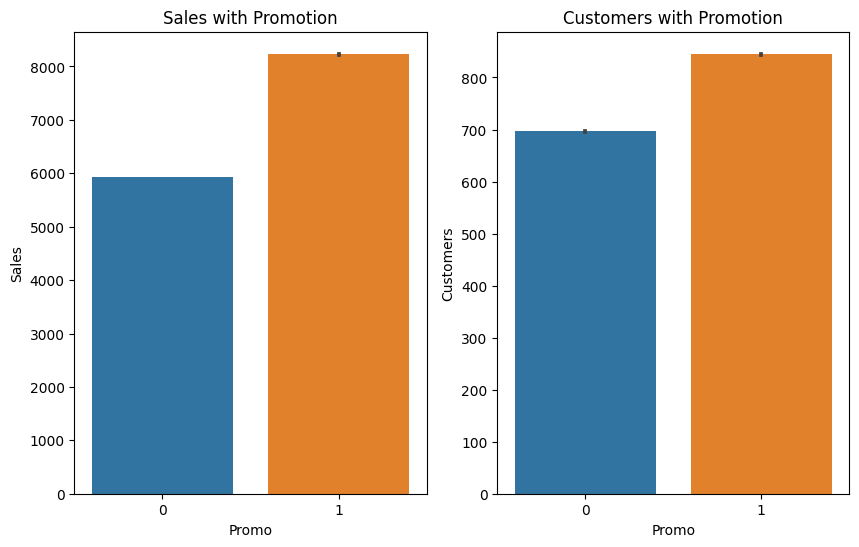

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_store is your DataFrame

# Create a figure with a specified size
plt.figure(figsize=(10, 6))

# Create the first bar plot for Sales with Promo
plt.subplot(1, 2, 1)
sns.barplot(x='Promo', y='Sales', data=train_store)
plt.title('Sales with Promotion')

# Create the second bar plot for Customers with Promo
plt.subplot(1, 2, 2)
sns.barplot(x='Promo', y='Customers', data=train_store)
plt.title('Customers with Promotion')

# Show the plots
plt.show()


Text(0, 0.5, 'Average Sales')

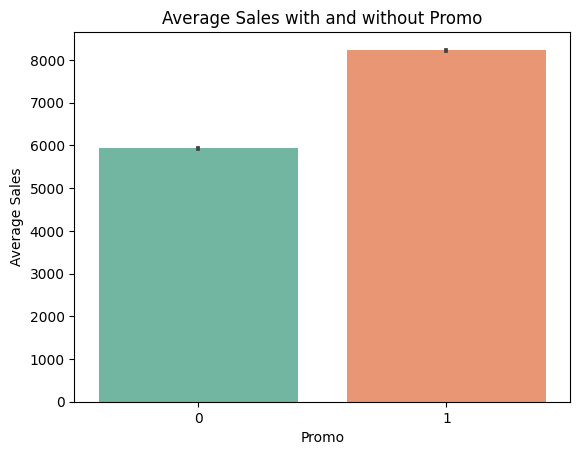

In [139]:
sns.barplot(data=train_store, x='Promo', y='Sales', palette='Set2')
plt.title('Average Sales with and without Promo')
plt.xlabel('Promo')
plt.ylabel('Average Sales')

Text(0, 0.5, 'Sales')

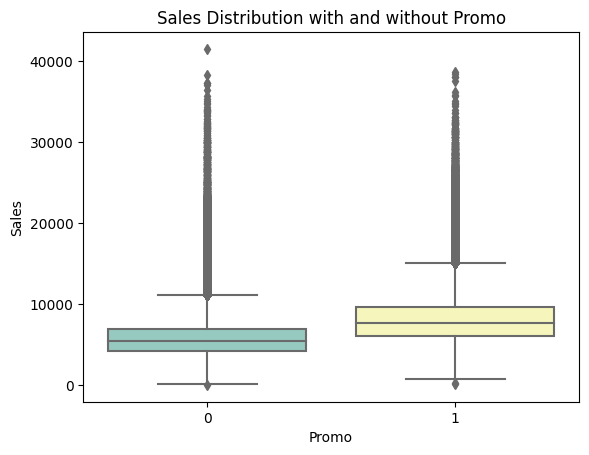

In [140]:
sns.boxplot(data=train_store, x='Promo', y='Sales', palette='Set3')
plt.title('Sales Distribution with and without Promo')
plt.xlabel('Promo')
plt.ylabel('Sales')

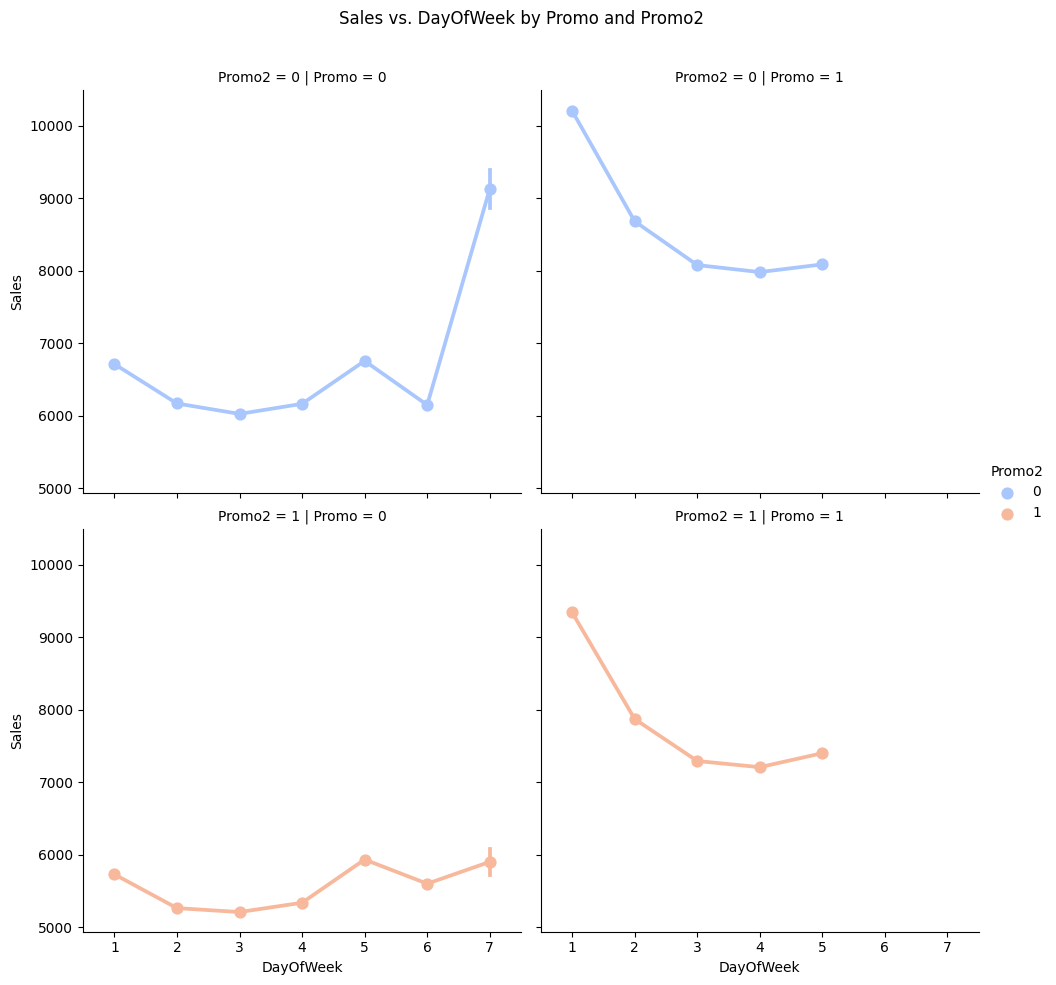

In [141]:
# Create the catplot
g = sns.catplot(data=train_store, x='DayOfWeek', y='Sales',
                col='Promo', row='Promo2', hue='Promo2', palette='coolwarm', kind='point')

# Customize the plot (optional)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Sales vs. DayOfWeek by Promo and Promo2')

# Show the plot
g.add_legend(title='Promo2')


In cases where there is no promotion (both Promo and Promo2 are equal to 0), sales tend to peak on Sundays. However, it's essential to note that StoreType C doesn't operate on Sundays, so this trend primarily reflects data from StoreType A, B, and D.

Conversely, stores that run promotions tend to achieve most of their sales on Mondays. This observation could serve as a valuable indicator for Rossmann's marketing campaigns. The same trend is followed by stores that have both promotions running simultaneously (Promo and Promo2 are equal to 1).

Promo2 alone doesn't appear to be correlated with any significant changes in the sales amount. This is further supported by the blue, pale area on the heatmap, indicating a lack of strong correlation between Promo2 and sales.

Text(0, 0.5, 'Sales')

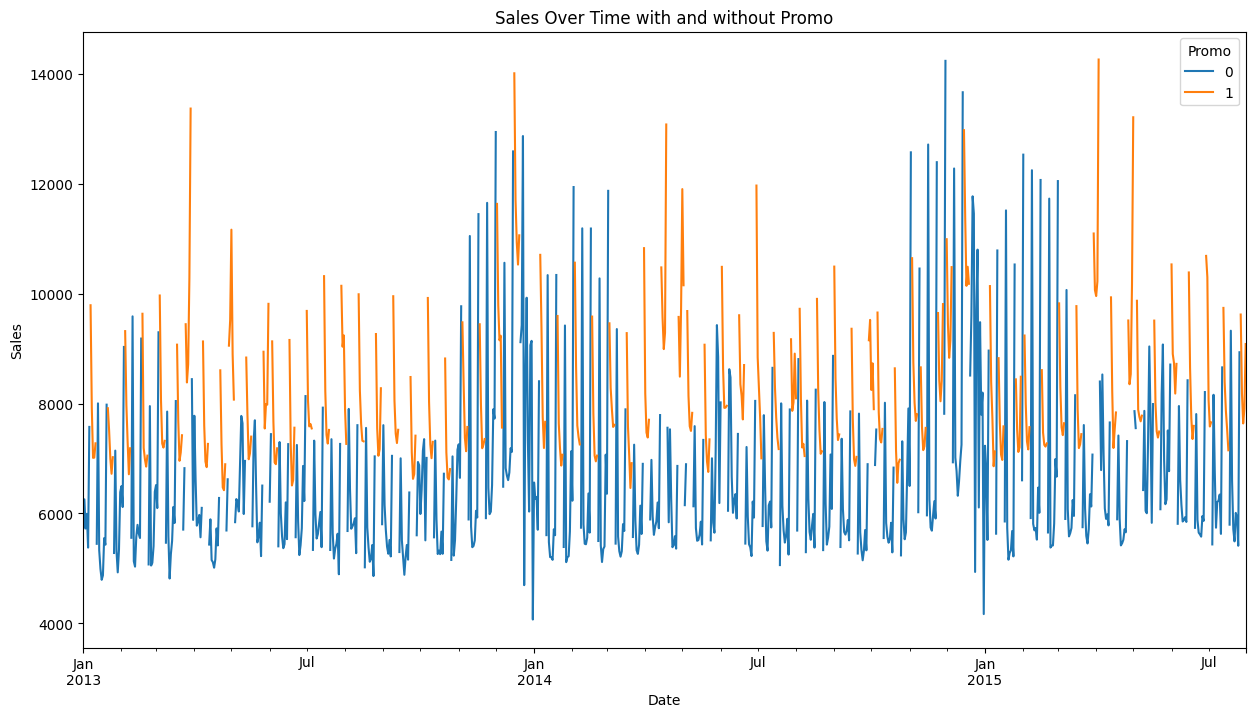

In [142]:
fig, ax = plt.subplots(figsize=(15, 8))
train_store.groupby(['Date', 'Promo']).mean()['Sales'].unstack().plot(ax=ax)
plt.title('Sales Over Time with and without Promo')
plt.xlabel('Date')
plt.ylabel('Sales')

<AxesSubplot: >

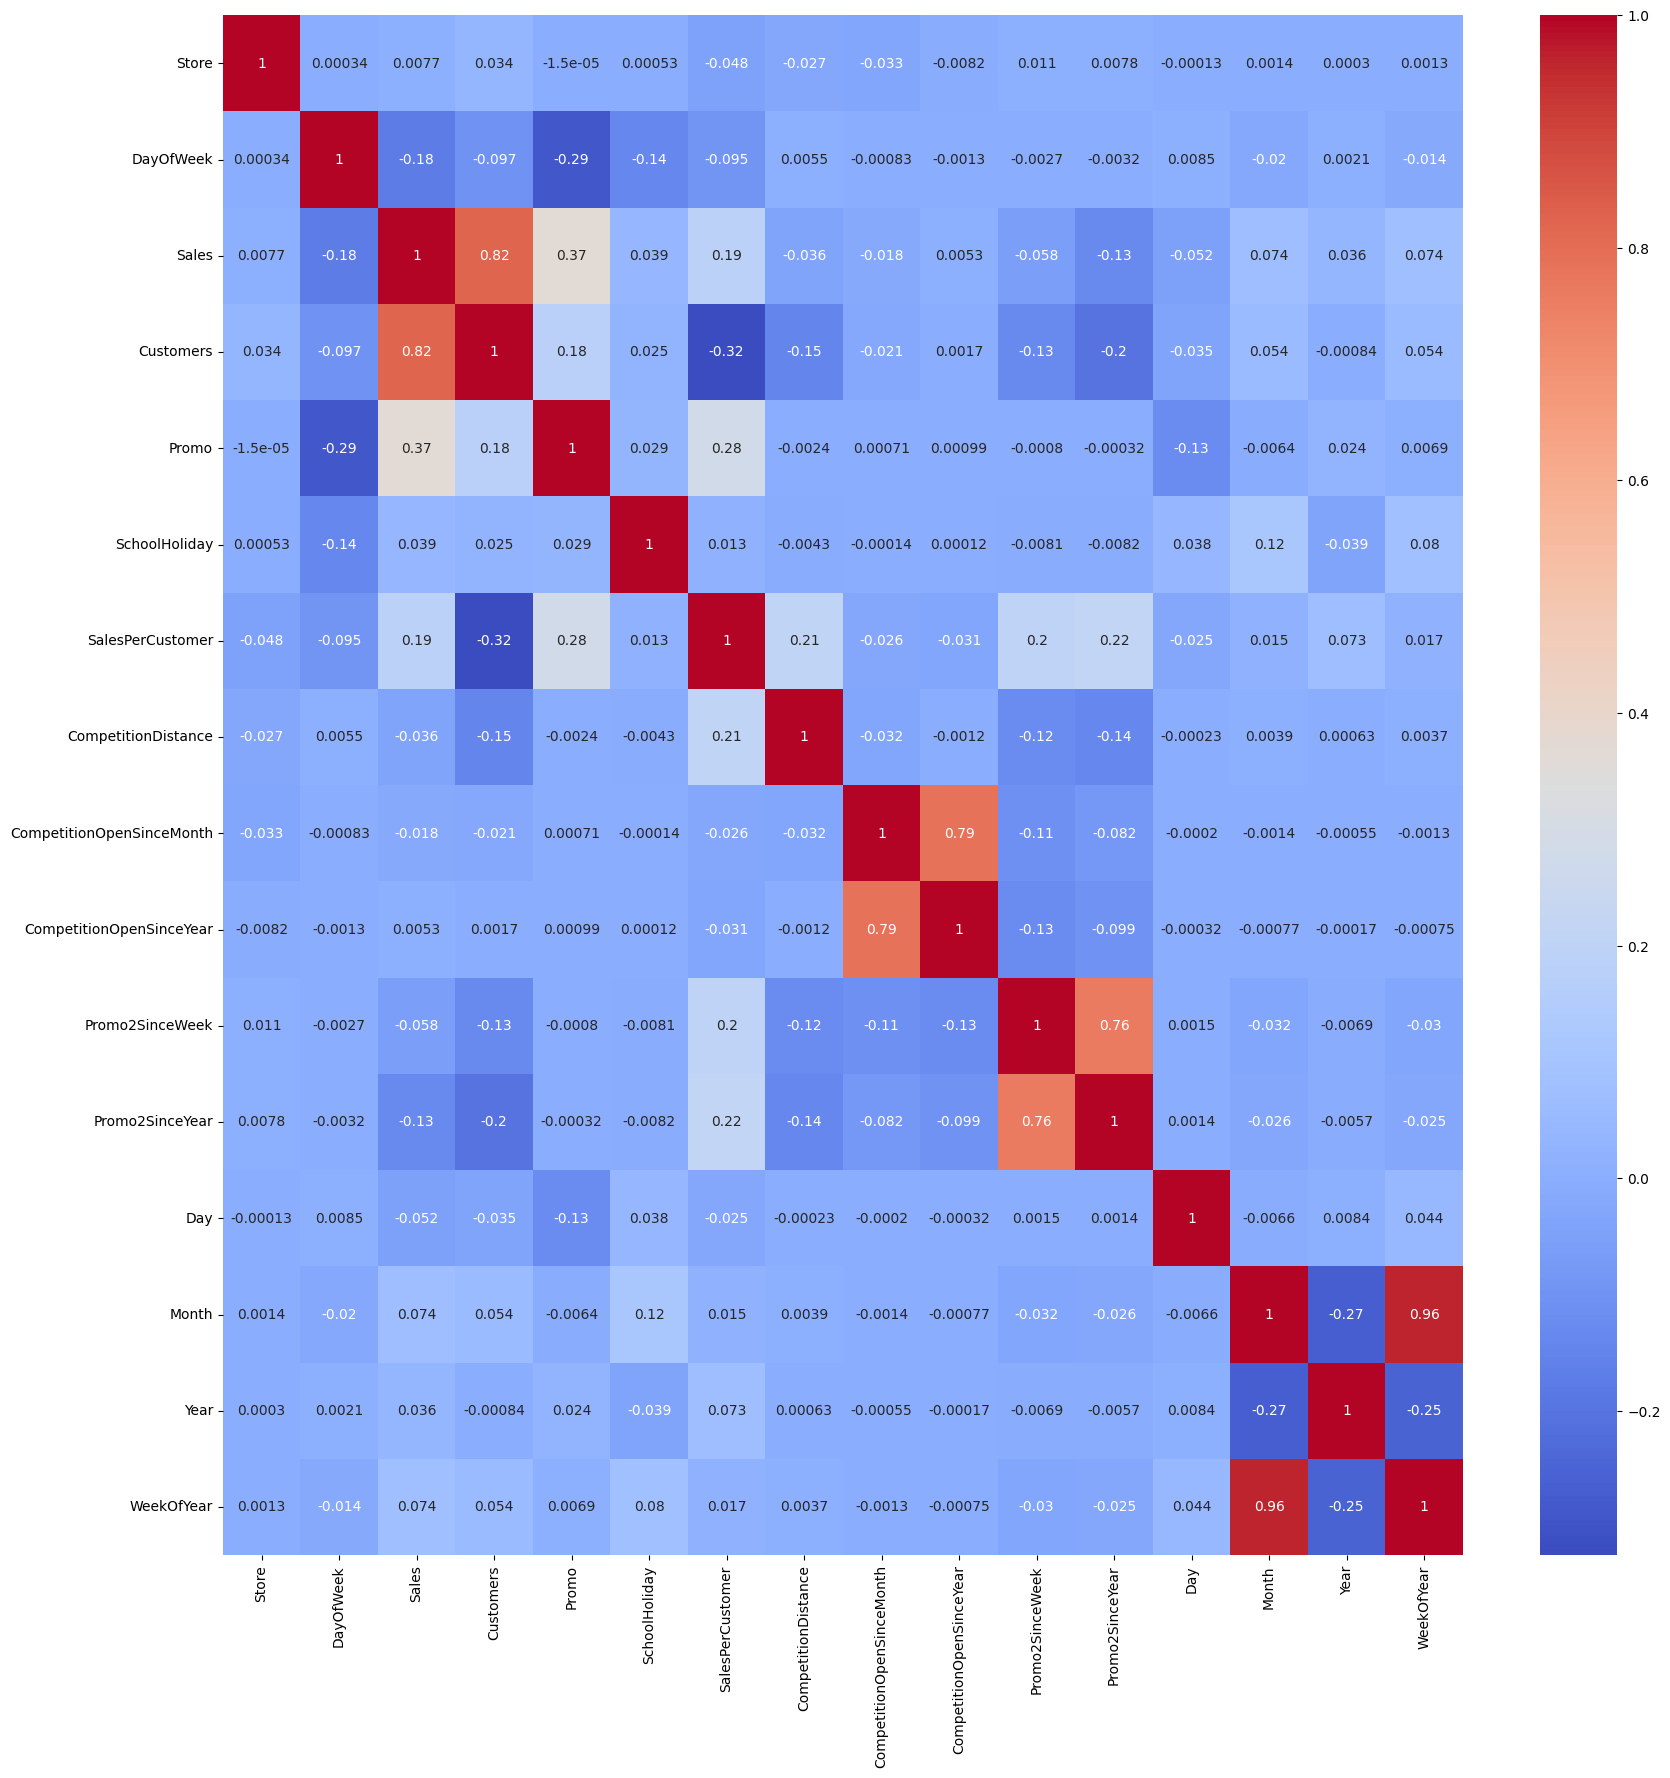

In [143]:
correlations =train_store.drop('Open', axis = 1).corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True, cmap = "coolwarm")

As mentioned previously, there is a strong positive correlation between the number of sales and the number of customers in a store. Additionally, a positive correlation is observed between the presence of a running promotion (Promo equal to 1) and the number of customers.

However, when a store continues with consecutive promotions (Promo2 equal to 1), the number of customers and sales seems to either remain the same or decrease. This is reflected in the pale negative correlation on the heatmap. A similar negative correlation is also seen between the presence of a promotion in the store and the day of the week.

In conclusion, here are the key findings from the exploratory data analysis (EDA) of Rossmann's sales data:

- StoreType A is the most selling and crowded StoreType.
- StoreType D has the highest "Sale per Customer," indicating a higher buyer cart. To leverage this, Rossmann can consider offering a broader variety of products.
- StoreType B has a lower "SalePerCustomer," suggesting that customers tend to buy smaller or fewer items. Despite generating the least amount of sales and having fewer customers overall, StoreType B shows potential for growth.
- Customers tend to make more purchases on Mondays when there's a single promotion (Promo) and on Sundays when there are no promotions at all (both Promo and Promo1 are equal to 0).
- Promo2 alone doesn't appear to be significantly correlated with changes in sales amount.
- These insights can help Rossmann make informed decisions about store types, promotion strategies, and customer behavior to improve its sales and overall performance.







### Seasonlaity Analysis


Time-Series Analysis per Store Type differs from a regular regression problem in the following ways:

- Time Dependency: Time series data is inherently time-dependent. Each data point is associated with a specific time or time interval. This temporal aspect introduces a dependency between observations, meaning that the value at one time point can be influenced by the values at previous time points. In contrast, traditional regression assumes that observations are independent of each other.

- Seasonality: Most time series data exhibits some form of seasonality. Seasonal trends refer to variations in the data that repeat at specific time intervals. For example, retail sales often have seasonality associated with holidays like Christmas or recurring patterns within a week.

- Store Type Analysis: In this case, the analysis is performed on store types, rather than individual stores. Aggregating data by store types simplifies the presentation and allows for capturing different trends and seasonal patterns present in the dataset. This approach helps in understanding the overall behavior of store types.

- Forecasting Methods: Time-series analysis often involves the use of specialized forecasting methods, such as Seasonal ARIMA (Autoregressive Integrated Moving Average) models or other time-series forecasting techniques. These methods are designed to capture and model the temporal patterns and dependencies present in the data.

- Prophet Methodology: The analysis mentions the use of the Prophet methodology for forecasting. Prophet is a time-series forecasting tool developed by Facebook, designed to handle time series with daily observations that display patterns on different time scales.

The goal of time-series analysis in this context is to understand the data, identify trends and seasonal patterns, and ultimately develop forecasts or models that can provide insights into future sales or other relevant metrics for store types.

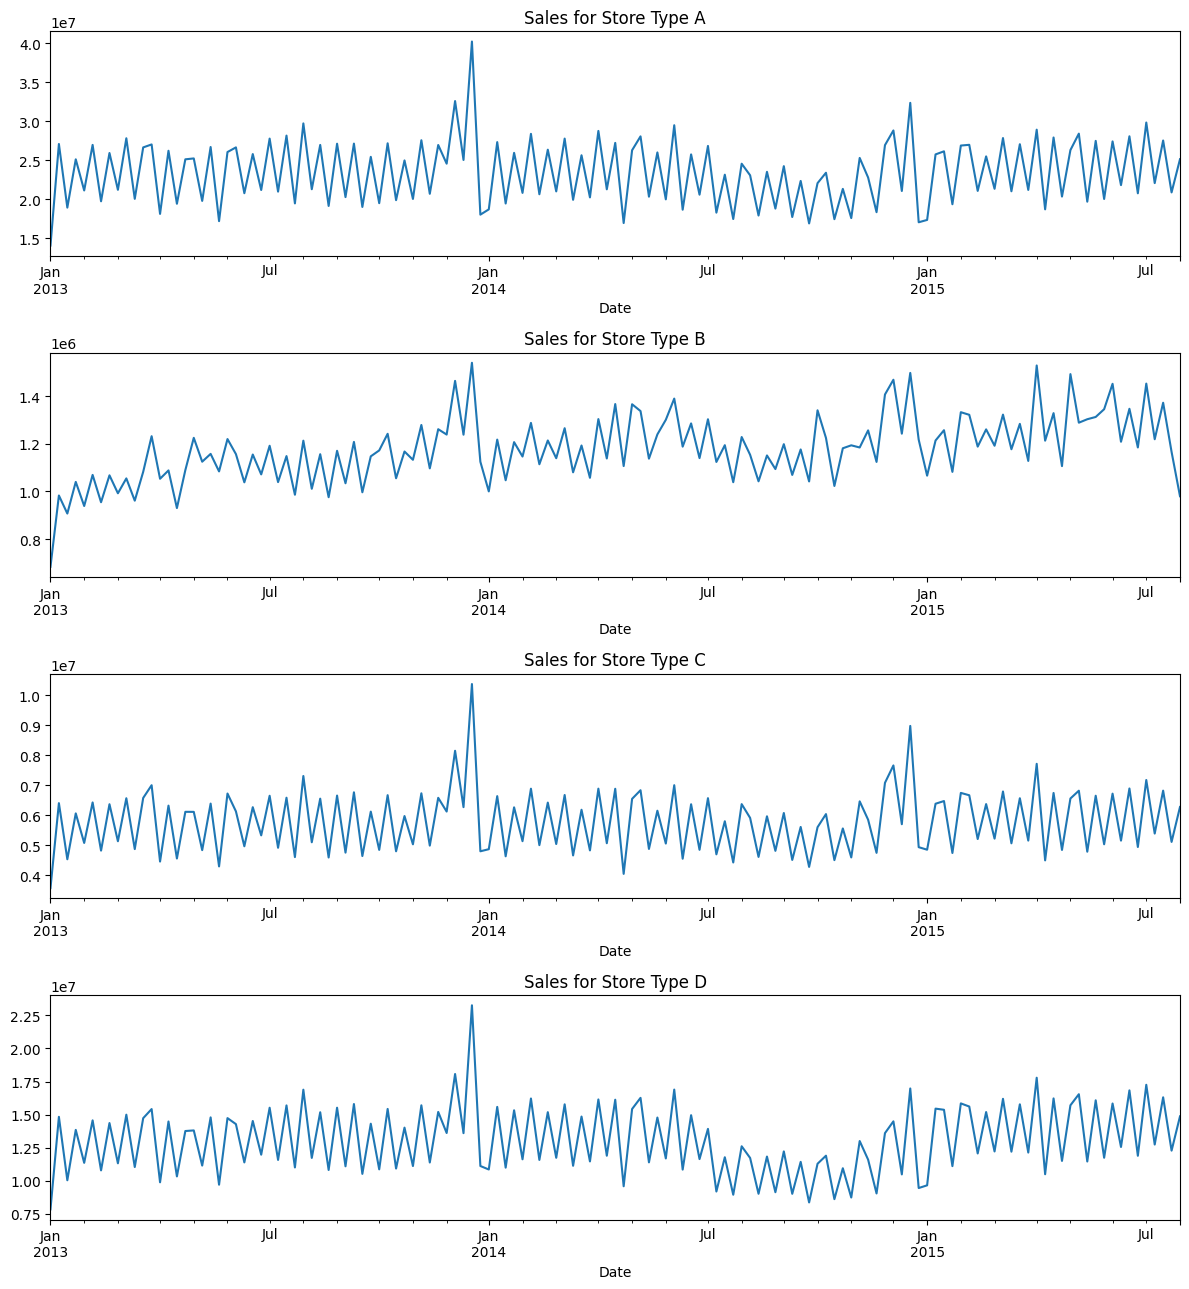

In [148]:
train_store.set_index('Date', inplace=True)

# Now you can use the resample method
sales_a = train_store[train_store.StoreType == 'a']['Sales']
sales_b = train_store[train_store.StoreType == 'b']['Sales']
sales_c = train_store[train_store.StoreType == 'c']['Sales']
sales_d = train_store[train_store.StoreType == 'd']['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))

sales_a.resample('W').sum().plot(ax=ax1)
ax1.set_title('Sales for Store Type A')

sales_b.resample('W').sum().plot(ax=ax2)
ax2.set_title('Sales for Store Type B')

sales_c.resample('W').sum().plot(ax=ax3)
ax3.set_title('Sales for Store Type C')

sales_d.resample('W').sum().plot(ax=ax4)
ax4.set_title('Sales for Store Type D')

plt.tight_layout()  # Automatically adjust to prevent overlapping

plt.show()



It's evident from the visualizations that retail sales for StoreType A and C tend to peak during the Christmas season and then decline after the holidays. However, for StoreType D (at the bottom of the visualization), the sales trend appears similar, but there is a gap in the data from July 2014 to January 2015. This gap likely indicates that these stores were closed during that period, and that's why there is no information available.

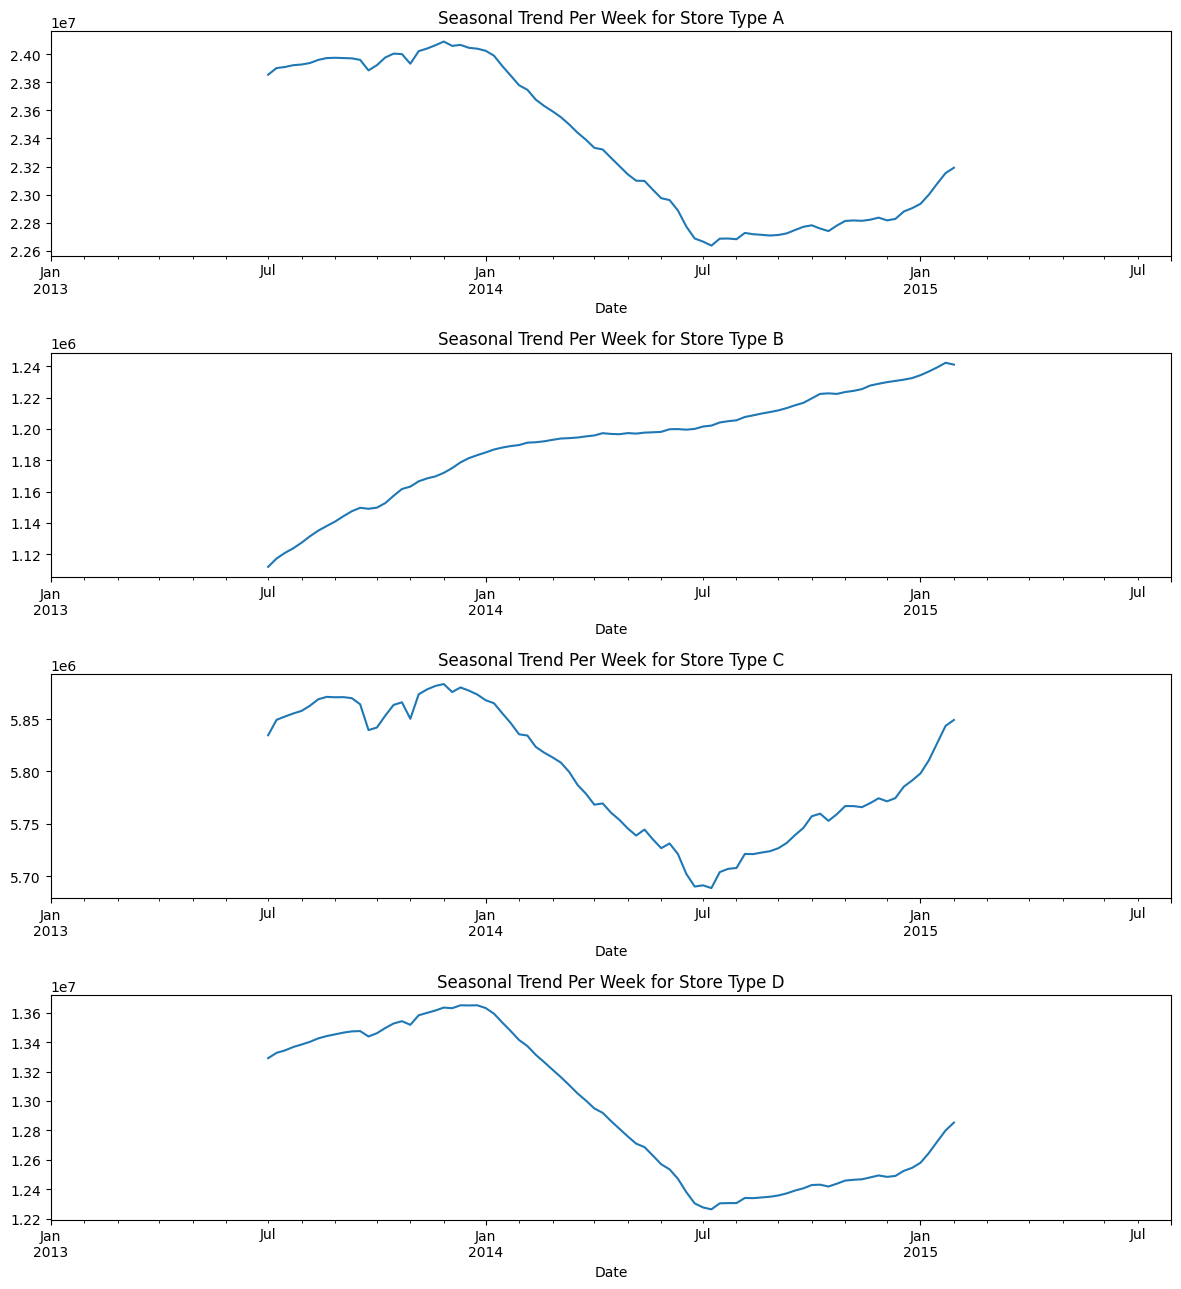

In [149]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 13))

# Decompose and plot sales_a
decomposition_a = seasonal_decompose(sales_a.resample('W').sum(), model='additive')
decomposition_a.trend.plot(ax=ax1)
ax1.set_title('Seasonal Trend Per Week for Store Type A')  # Updated title

# Decompose and plot sales_b
decomposition_b = seasonal_decompose(sales_b.resample('W').sum(), model='additive')
decomposition_b.trend.plot(ax=ax2)
ax2.set_title('Seasonal Trend Per Week for Store Type B')  # Updated title

# Decompose and plot sales_c
decomposition_c = seasonal_decompose(sales_c.resample('W').sum(), model='additive')
decomposition_c.trend.plot(ax=ax3)
ax3.set_title('Seasonal Trend Per Week for Store Type C')  # Updated title

# Decompose and plot sales_d
decomposition_d = seasonal_decompose(sales_d.resample('W').sum(), model='additive')
decomposition_d.trend.plot(ax=ax4)
ax4.set_title('Seasonal Trend Per Week for Store Type D')  # Updated title

plt.tight_layout()  # Automatically adjust to prevent overlapping

plt.show()


Overall sales seems to increase


Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots are essential tools in time series analysis:

* Autocorrelation Function (ACF): ACF measures the correlation between a time series and a lagged version of itself. For example, at lag 5, ACF compares the series at time instants 't1' to 'tn' with the series at time instants 't1-5' to 'tn-5' (where 't1-5' and 'tn' are the endpoints). ACF provides insights into how the series correlates with its past values, revealing patterns or repeating cycles.

* Partial Autocorrelation Function (PACF): PACF also measures the correlation between a time series and a lagged version of itself, but it eliminates the variations already explained by the intervening comparisons. For example, at lag 5, PACF checks the correlation but removes the effects explained by lags 1 to 4. PACF helps identify the direct influence of specific lagged values on the current value, helping in identifying the order of autoregressive (AR) terms in time series modeling.

These plots are crucial for understanding the temporal dependencies in time series data, which is essential for modeling and forecasting future values.

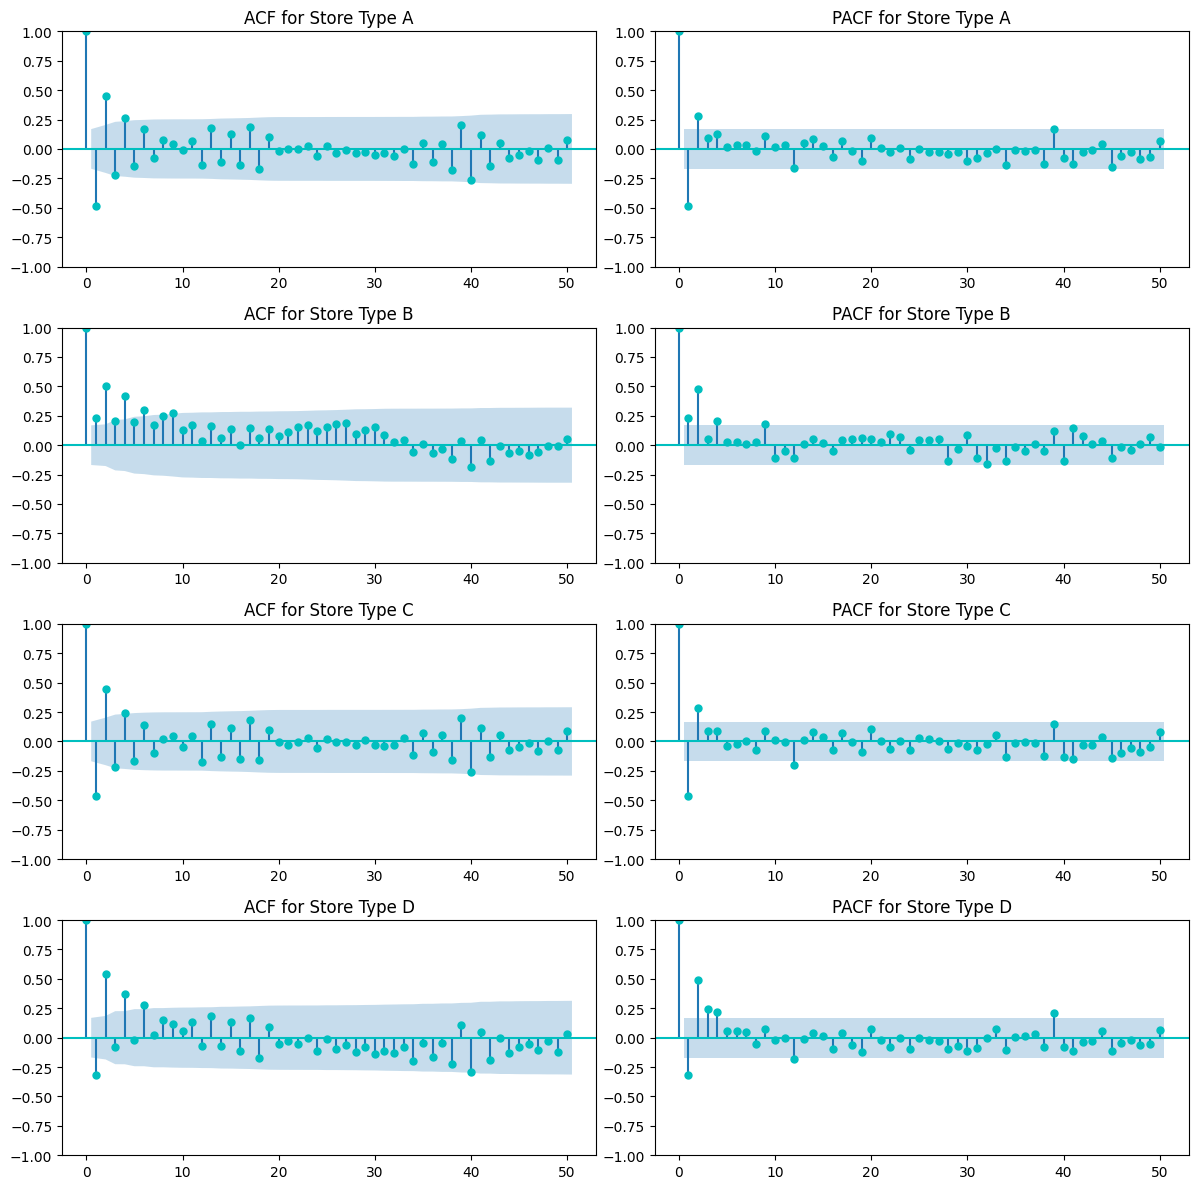

In [151]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Plot ACF and PACF for Store Type A
plot_acf(sales_a.resample('W').sum(), lags=50, ax=axes[0, 0], color='c')
axes[0, 0].set_title('ACF for Store Type A')
plot_pacf(sales_a.resample('W').sum(), lags=50, ax=axes[0, 1], color='c')
axes[0, 1].set_title('PACF for Store Type A')

# Plot ACF and PACF for Store Type B
plot_acf(sales_b.resample('W').sum(), lags=50, ax=axes[1, 0], color='c')
axes[1, 0].set_title('ACF for Store Type B')
plot_pacf(sales_b.resample('W').sum(), lags=50, ax=axes[1, 1], color='c')
axes[1, 1].set_title('PACF for Store Type B')

# Plot ACF and PACF for Store Type C
plot_acf(sales_c.resample('W').sum(), lags=50, ax=axes[2, 0], color='c')
axes[2, 0].set_title('ACF for Store Type C')
plot_pacf(sales_c.resample('W').sum(), lags=50, ax=axes[2, 1], color='c')
axes[2, 1].set_title('PACF for Store Type C')

# Plot ACF and PACF for Store Type D
plot_acf(sales_d.resample('W').sum(), lags=50, ax=axes[3, 0], color='c')
axes[3, 0].set_title('ACF for Store Type D')
plot_pacf(sales_d.resample('W').sum(), lags=50, ax=axes[3, 1], color='c')
axes[3, 1].set_title('PACF for Store Type D')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


Prophet Prediction

Prophet is a powerful time series forecasting tool developed by Facebook's Core Data Science team. It uses an additive model that accommodates non-linear trends, yearly and weekly seasonality, and even holidays. Prophet allows for automated forecasting and has been implemented in both R and Python, making it a scalable and versatile solution for time series forecasting.

In your specific use case, you want to use Prophet to forecast sales data for the first store for the next 6 weeks. You can leverage Prophet's capabilities to analyze historical sales data and make predictions about future sales trends, helping you plan and make informed decisions. This approach is valuable in various industries, including retail, finance, and demand forecasting, among others.







In [152]:
def select_data(store_id, df):
    # Filter out rows where the store is open and sales are non-zero
    df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
    
    # Select sales data for the specified store
    sales = df[df.Store == store_id].loc[:, ['Date', 'Sales']]
    
    # Rename columns to match the format expected by Prophet
    sales = sales[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    
    # Sort the sales data by date
    sales = sales.sort_values(by='ds')
    
    # Display the sales data
    display(sales)
    
    # Print information about the store
    print("Store number", store_id, "(StoreType:", store[store.Store == store_id].loc[:, 'StoreType'].values[0], ")")
    
    # Create a plot of the sales data
    ax = sales.plot(figsize=(12, 4))
    ax.set_ylabel('Daily Number of Sales')
    ax.set_xlabel('Date')
    plt.show()
    
    return sales


ds     y
1014980  2013-01-02  5530
1013865  2013-01-03  4327
1012750  2013-01-04  4486
1011635  2013-01-05  4997
1009405  2013-01-07  7176
...             ...   ...
4460     2015-07-27  6102
3345     2015-07-28  5011
2230     2015-07-29  4782
1115     2015-07-30  5020
0        2015-07-31  5263

[781 rows x 2 columns]

Store number 1 (StoreType: c )


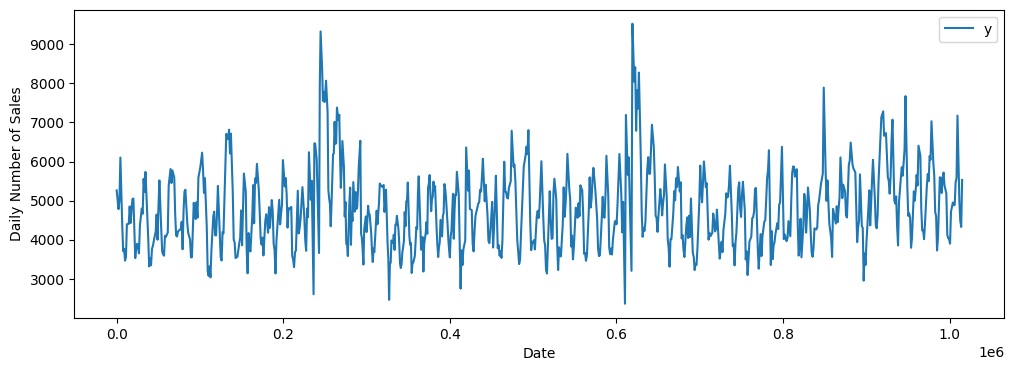

In [155]:
train = pd.read_csv("train.csv", low_memory = False)
sales_df = select_data(1,train)


In [156]:
sales_df

ds     y
1014980  2013-01-02  5530
1013865  2013-01-03  4327
1012750  2013-01-04  4486
1011635  2013-01-05  4997
1009405  2013-01-07  7176
...             ...   ...
4460     2015-07-27  6102
3345     2015-07-28  5011
2230     2015-07-29  4782
1115     2015-07-30  5020
0        2015-07-31  5263

[781 rows x 2 columns]

In [157]:
def sales_prediction(interval_width, sales_df, periods, holidays):
    # Create a Prophet model with the specified parameters
    model = Prophet(interval_width=interval_width, holidays=holidays)
    
    # Fit the model to the sales data
    model.fit(sales_df)
    
    # Create a future DataFrame for making predictions
    future = model.make_future_dataframe(periods=periods)
    
    # Generate the forecast using the trained model
    forecast = model.predict(future)
    
    # Plot the forecast and components
    figure1 = model.plot(forecast, xlabel='Date', ylabel='Sales')
    figure2 = model.plot_components(forecast)
    
    # Display the last 'periods' rows of the forecast, including date, predicted values, lower and upper bounds
    display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods))
    
    # Return both the original sales data and the forecast
    return sales_df, forecast


The code forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() is used to display the last seven rows of the forecast DataFrame. These columns are:

- 'ds': Date (timestamp).
- 'yhat': The forecasted value.
- 'yhat_lower': The lower bound of the uncertainty interval.
- 'yhat_upper': The upper bound of the uncertainty interval.

By using .tail(), you are showing the most recent seven forecasted values along with their associated uncertainty intervals. This information can be useful for understanding the model's predictions for the near future and assessing the level of uncertainty in those predictions. It's common to examine the last few forecasted values to gain insights into the short-term trends and predictions.

13:31:00 - cmdstanpy - INFO - Chain [1] start processing
13:31:01 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
781  2015-08-01  4562.773569  3149.755592  6100.805281
782  2015-08-02  4530.540083  3157.471372  5996.502569
783  2015-08-03  4742.617101  3367.068846  6142.495840
784  2015-08-04  4224.353014  2895.269058  5655.441424
785  2015-08-05  4081.155555  2718.032743  5470.139144
...         ...          ...          ...          ...
1141 2016-07-26  4405.005107  2930.949110  5805.608336
1142 2016-07-27  4267.636236  2786.871754  5660.031617
1143 2016-07-28  4155.001669  2785.627296  5665.878505
1144 2016-07-29  4384.084167  3067.438148  5719.705172
1145 2016-07-30  4562.119029  3135.805889  5910.911486

[365 rows x 4 columns]

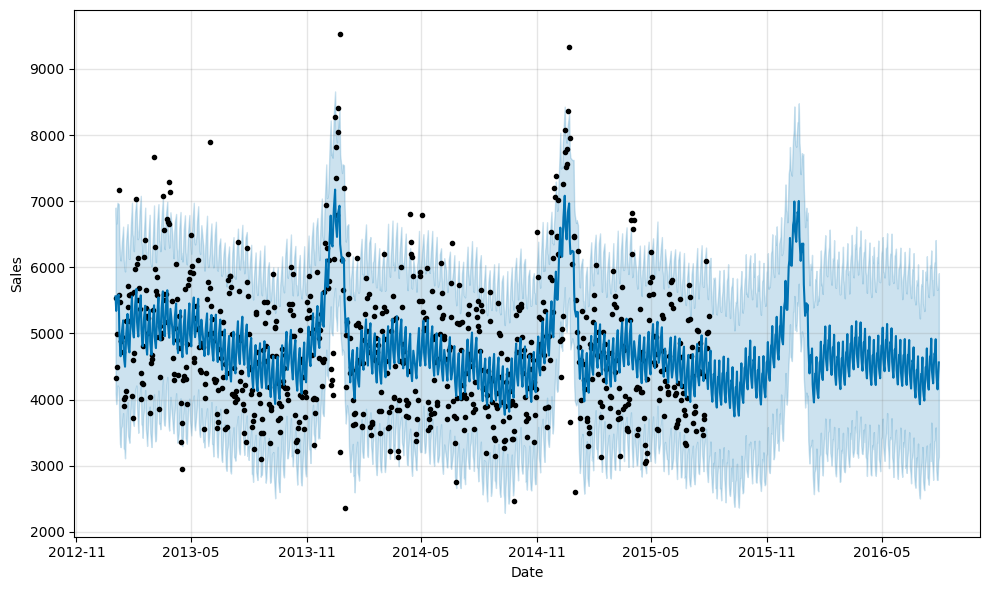

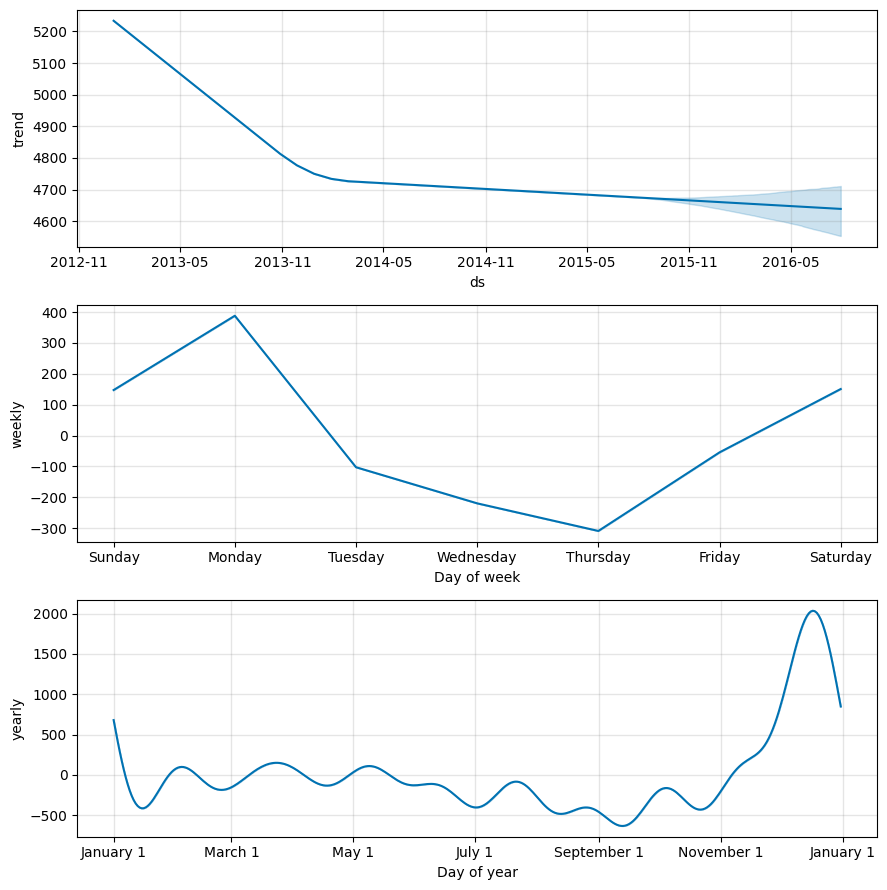

In [158]:
df_origin, df_prediction = sales_prediction(0.90,sales_df,365,None)


Prophet's ability to capture and model trends in time series data, as well as its accuracy in predicting future values, is a valuable feature for time series forecasting. It's evident that Prophet can effectively capture the underlying patterns in the data, making it a powerful tool for forecasting.

Furthermore, one of Prophet's strong features is its ability to decompose the forecasted values into their individual components. This means it can provide insights into how daily, weekly, and yearly patterns, along with manually included holidays, contribute to the overall forecasted values. This decomposition is essential for understanding the different factors driving the time series and can be used for in-depth analysis and interpretation of the forecasted results. It allows data analysts and forecasters to gain a clear understanding of what influences the predictions and how different components interact to shape the future values of the time series.

Prophet's ability to model holidays is a valuable feature in time series forecasting. In this context, it's used to account for the impact of holidays on sales data. The dataset includes two types of holidays:

- State Holidays: These are holidays on which all stores are normally closed. State holidays typically affect all stores and result in reduced or zero sales.

- School Holidays: These holidays affect specific stores, leading them to close their doors. Unlike state holidays, school holidays don't necessarily impact all stores and may lead to closures for only certain locations.

By modeling these holidays, Prophet can capture the effect of these events on sales data, allowing for more accurate and informative forecasting. It's a way to account for special days when the usual sales patterns may be disrupted, and their influence on sales can be explicitly considered in the model.

In [159]:
# State holidays
state_dates = train[train.StateHoliday.isin(['a', 'b', 'c'])]['Date']
state_holidays = pd.DataFrame({'holiday': 'state_holiday', 'ds': pd.to_datetime(state_dates)})

# School holidays
school_dates = train[train.SchoolHoliday == 1]['Date']
school_holidays = pd.DataFrame({'holiday': 'school_holiday', 'ds': pd.to_datetime(school_dates)})

# Combine both holiday types
holidays = pd.concat([state_holidays, school_holidays])

# Display the first few rows of the 'holidays' DataFrame
holidays.head()


holiday         ds
63555  state_holiday 2015-06-04
63557  state_holiday 2015-06-04
63559  state_holiday 2015-06-04
63560  state_holiday 2015-06-04
63563  state_holiday 2015-06-04

13:32:18 - cmdstanpy - INFO - Chain [1] start processing
13:32:18 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
781  2015-08-01  4294.212009  2973.969780  5725.981572
782  2015-08-02  4257.823809  2964.628200  5653.083858
783  2015-08-03  4311.300171  3016.056097  5617.485360
784  2015-08-04  3785.933431  2373.614640  5144.355926
785  2015-08-05  3637.121412  2229.420682  4915.547996
...         ...          ...          ...          ...
1141 2016-07-26  3974.463232  2515.713367  5327.146623
1142 2016-07-27  3827.727643  2411.133197  5106.614959
1143 2016-07-28  3713.959097  2305.458845  5067.635974
1144 2016-07-29  3929.337714  2666.355727  5257.109722
1145 2016-07-30  4294.518491  3008.412801  5668.558220

[365 rows x 4 columns]

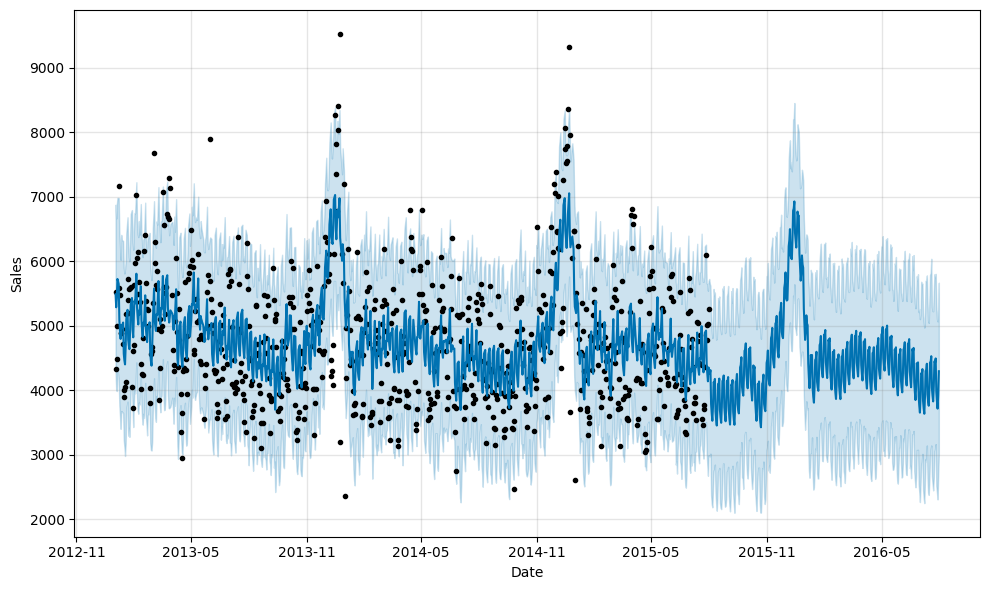

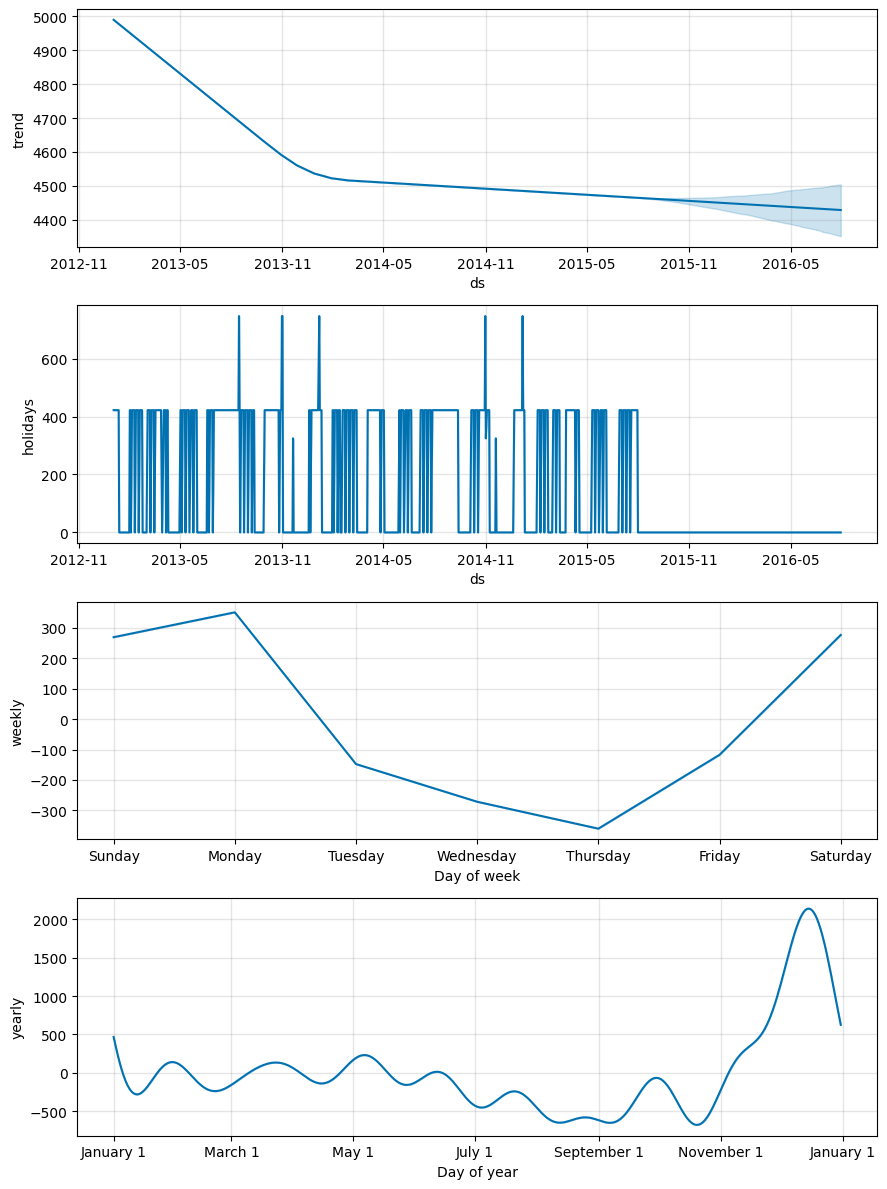

In [160]:
df_origin, df_prediction = sales_prediction(0.90,sales_df,365,holidays)


The description you provided corresponds to the components shown in the Prophet model's decomposition. Here's a breakdown of what each plot represents:

- Monthly Sales Trend: The first plot illustrates the monthly sales trend for store number 1. It shows that the sales have been linearly decreasing over time, indicating a declining trend in monthly sales.

- Holiday Effects: The second plot displays the holidays included in the model. It highlights the specific dates and periods of holidays that have been considered in the time series analysis.

- Weekly Sales Trend: The third plot highlights the weekly sales trend, indicating that the volume of sales from the previous week tends to peak towards the beginning of the new week, particularly on Mondays. This shows a recurring pattern in weekly sales.

- Seasonal Pattern: The fourth plot shows the most busy season during the Christmas holidays. It illustrates how the model captures the seasonality of the data, with a significant increase in sales during the Christmas holiday season.

These components provide valuable insights into the underlying patterns and trends within the time series data and help in understanding how different factors, including holidays and weekly or seasonal effects, contribute to the overall sales forecast.